In [33]:
# 📅 DATE CONFIGURATION - Set your target analysis date here
TARGET_DATE = "2025-07-30"  # Format: YYYY-MM-DD

print(f"🎯 MAV Route Analysis configured for: {TARGET_DATE}")
print("=" * 50)

# 📦 Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
from datetime import datetime, timedelta
from google.cloud import storage
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# 🎨 Configure plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 12
sns.set_palette("husl")

print("✅ Libraries loaded successfully!")
print("🎯 Ready for MAV route histogram analysis")


🎯 MAV Route Analysis configured for: 2025-07-30
✅ Libraries loaded successfully!
🎯 Ready for MAV route histogram analysis


In [37]:
# 🌩️ Load MAV route data from Google Cloud Storage
def upload_mav_data_to_gcs(data, filename, target_date=TARGET_DATE, bucket_name='mpt-all-sources'):
    """
    Uploads a dict (or JSON-serializable object) to GCS as a compact JSON file for the given date.

    Args:
        data (dict or list): The data to upload (will be JSON-serialized)
        filename (str): The base filename (e.g. 'bulk_004301974_005501289_20250730_191728_compact.json')
        target_date (str): Date in YYYY-MM-DD format (default: TARGET_DATE)
        bucket_name (str): GCS bucket name (default: 'mpt-all-sources')
    """
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    # Compose the GCS path
    gcs_path = f"blog/mav/json_output/{target_date}/{filename}"
    blob = bucket.blob(gcs_path)
    # Serialize data to JSON
    json_data = json.dumps(data, ensure_ascii=False, indent=2)
    # Upload to GCS
    blob.upload_from_string(json_data, content_type='application/json')
    print(f"✅ Uploaded data to gs://{bucket_name}/{gcs_path}")

def load_mav_data_from_gcs(bucket_name='mpt-all-sources', target_date=TARGET_DATE):
    """
    Load MAV route data from GCS bucket with automatic date fallback.
    
    Args:
        bucket_name (str): GCS bucket name
        target_date (str): Date in YYYY-MM-DD format (uses TARGET_DATE from config)
    
    Returns:
        list: Processed route data ready for analysis
    """
    print(f"🔍 Loading MAV data from: gs://{bucket_name}/blog/mav/json_output/")
    print(f"📅 Target date: {target_date}")
    
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    
    # Try target date first, then fallback to previous days
    for days_back in range(8):
        try_date = (datetime.strptime(target_date, '%Y-%m-%d') - timedelta(days=days_back)).strftime('%Y-%m-%d')
        gcs_prefix = f"blog/mav/json_output/{try_date}/"
        
        print(f"🔄 Trying date: {try_date}")
        
        # List compact JSON files
        blobs = list(bucket.list_blobs(prefix=gcs_prefix))
        compact_blobs = [blob for blob in blobs if blob.name.endswith('_compact.json')]
        
        if compact_blobs:
            print(f"✅ Found {len(compact_blobs)} files for {try_date}")
            
            # Process the data
            routes_data = []
            latest_blobs = {}
            for i, blob in enumerate(compact_blobs):
                if i % 25 == 0:
                    print(f"📊 Processing file {i+1}/{len(compact_blobs)}...")
                
                # --- Group blobs by (start_station, end_station), keep only latest timestamp ---
                filename = blob.name.split('/')[-1]
                match = re.match(r'bulk_(\d+)_(\d+)_(\d{8}_\d{6})_compact\.json', filename)
                
                if not match:
                    print(f"⚠️ Filename pattern not matched: {filename}")
                    continue
                
                start_station, end_station, timestamp = match.groups()
                key = (start_station, end_station)
        
                # Compare timestamps lexicographically (YYYYMMDD_HHMMSS format)
                if key not in latest_blobs or timestamp > latest_blobs[key][0]:
                    latest_blobs[key] = (timestamp, blob)
            print(f"🎯 Found {len(latest_blobs)} unique station pairs vs {len(compact_blobs)} total files")
            # latest_blobs: key = (start_station, end_station), value = (timestamp, blob)
            for i, ((start_station, end_station), (timestamp, blob)) in enumerate(latest_blobs.items()):
                json_content = json.loads(blob.download_as_text())
                # Extract route information
                for route in json_content['routes']:
                    routes_data.append({
                        'start_station': start_station,
                        'end_station': end_station,
                        'end_station_name': route.get('route_segments',[])[-1].get('end_station', 'Unknown'),
                        'start_station_name': route.get('route_segments', [])[0].get('start_station', 'Unknown'),
                        'station_pair': f"{start_station}_{end_station}",
                        'timestamp': timestamp,
                        'date': try_date,
                        'train_name': route.get('train_name', 'Unknown'),
                        'departure_time': route.get('departure_time'),
                        'arrival_time': route.get('arrival_time'),
                        'travel_time_min': route.get('travel_time_min', '00:00'),
                        'delay_min': route.get('delay_min', 0),
                        'departure_delay_min': route.get('departure_delay_min', 0),
                        'arrival_delay_min': route.get('arrival_delay_min', 0),
                        'is_delayed': route.get('delay_min', 0) > 2,
                        'is_significantly_delayed': route.get('is_significantly_delayed', False),
                        'transfers_count': route.get('transfers_count', 0),
                        'price_huf': route.get('price_huf', 0),
                        'has_actual_times': route.get('has_actual_times', False)
                    })
            
            if routes_data:
                print(f"🎯 Successfully loaded {len(routes_data)} route records!")
                return routes_data
        
        print(f"❌ No data found for {try_date}")
    
    raise Exception("❌ No MAV data found in the last 8 days!")

# Load the data
print("\n" + "="*60)
print("🚀 LOADING DATA FROM GOOGLE CLOUD STORAGE")
print("="*60)

raw_data = load_mav_data_from_gcs()
df = pd.DataFrame(raw_data)

print(f"\n📈 Dataset Overview:")
print(f"   • Total routes: {len(df):,}")
print(f"   • Unique station pairs: {df['station_pair'].nunique():,}")
print(f"   • Date range: {df['date'].min()} to {df['date'].max()}")
print(f"   • Sample columns: {list(df.columns)[:8]}...")



🚀 LOADING DATA FROM GOOGLE CLOUD STORAGE
🔍 Loading MAV data from: gs://mpt-all-sources/blog/mav/json_output/
📅 Target date: 2025-07-30
🔄 Trying date: 2025-07-30
✅ Found 70 files for 2025-07-30
📊 Processing file 1/70...
📊 Processing file 26/70...
📊 Processing file 51/70...
🎯 Found 69 unique station pairs vs 70 total files
🎯 Successfully loaded 626 route records!

📈 Dataset Overview:
   • Total routes: 626
   • Unique station pairs: 69
   • Date range: 2025-07-30 to 2025-07-30
   • Sample columns: ['start_station', 'end_station', 'end_station_name', 'start_station_name', 'station_pair', 'timestamp', 'date', 'train_name']...


In [ ]:
# def all_data():
#     """
#     Loads all available MAV route data from Google Cloud Storage for all available dates.
#     Returns a pandas DataFrame containing the concatenated data.
#     """
#     import pandas as pd

#     # List of available dates/folders to load
#     available_dates = [
#         "2025-07-15",
#         "2025-07-17",
#         "2025-07-18",
#         "2025-07-19",
#         "2025-07-21",
#         "2025-07-22",
#         "2025-07-23",
#         "2025-07-24",
#         "2025-07-25",
#         "2025-07-26",
#         "2025-07-28"
#     ]

#     all_records = []
#     for date in available_dates:
#         try:
#             print(f"Loading data for {date}...")
#             data = load_mav_data_from_gcs(target_date=date)
#             all_records.extend(data)
#         except Exception as e:
#             print(f"⚠️ Could not load data for {date}: {e}")

#     if not all_records:
#         raise Exception("❌ No MAV data found for any of the available dates!")

#     df_all = pd.DataFrame(all_records)
#     print(f"✅ Loaded {len(df_all)} records from {len(available_dates)} dates.")
#     return df_all

# df_all = all_data()



Loading data for 2025-07-15...
🔍 Loading MAV data from: gs://mpt-all-sources/blog/mav/json_output/
📅 Target date: 2025-07-15
🔄 Trying date: 2025-07-15
✅ Found 127 files for 2025-07-15
📊 Processing file 1/127...
📊 Processing file 26/127...
📊 Processing file 51/127...
📊 Processing file 76/127...
📊 Processing file 101/127...
📊 Processing file 126/127...
🎯 Successfully loaded 1373 route records!
Loading data for 2025-07-17...
🔍 Loading MAV data from: gs://mpt-all-sources/blog/mav/json_output/
📅 Target date: 2025-07-17
🔄 Trying date: 2025-07-17
✅ Found 126 files for 2025-07-17
📊 Processing file 1/126...
📊 Processing file 26/126...
📊 Processing file 51/126...
📊 Processing file 76/126...
📊 Processing file 101/126...
📊 Processing file 126/126...
🎯 Successfully loaded 1385 route records!
Loading data for 2025-07-18...
🔍 Loading MAV data from: gs://mpt-all-sources/blog/mav/json_output/
📅 Target date: 2025-07-18
🔄 Trying date: 2025-07-18
✅ Found 125 files for 2025-07-18
📊 Processing file 1/125...

In [ ]:
# df_all

,start_station,end_station,end_station_name,start_station_name,station_pair,timestamp,date,train_name,departure_time,arrival_time,travel_time_min,delay_min,departure_delay_min,arrival_delay_min,is_delayed,is_significantly_delayed,transfers_count,price_huf,has_actual_times
0,004250274,005513821,Kisújszállás,Kál-Kápolna,004250274_005513821,20250715_232409,2025-07-15,36562,09:38,11:29,01:54,9,9,0,True,True,0,1490,True
1,004250274,005513821,Kisújszállás,Kál-Kápolna,004250274_005513821,20250715_232409,2025-07-15,"5097, 35714, 6004 (CÍVIS)",09:51,13:24,03:36,1,1,-186,False,False,2,2830,True
2,004250274,005513821,Kisújszállás,Kál-Kápolna,004250274_005513821,20250715_232409,2025-07-15,36554,12:38,14:20,01:45,3,0,3,True,False,0,1490,True
3,004250274,005513821,Kisújszállás,Kál-Kápolna,004250274_005513821,20250715_232409,2025-07-15,36556,14:38,16:29,01:54,7,7,0,True,True,0,1490,True
4,004250274,005513821,"Kisújszállás, vasútállomás","Kál-Kápolna, vasútállomás",004250274_005513821,20250715_232409,2025-07-15,"3443/16, 1050/13, 1375/115",15:13,18:39,03:29,0,0,0,False,False,2,2520,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17484,005502121,005502170,Celldömölk,Pápa,005502121_005502170,20250728_222902,2025-07-28,9224,13:02,13:32,00:30,4,4,2,True,False,0,550,True
17485,005502121,005502170,Celldömölk,Pápa,005502121_005502170,20250728_222902,2025-07-28,9695 (HELIKON),14:02,14:25,00:23,1,1,1,False,False,0,550,True
17486,005502121,005502170,Celldömölk,Pápa,005502121_005502170,20250728_222902,2025-07-28,9216,15:02,15:32,00:30,0,0,-1,False,False,0,550,True
17487,005502121,005502170,Celldömölk,Pápa,005502121_005502170,20250728_222902,2025-07-28,9236,15:45,16:17,00:32,0,0,0,False,False,0,550,True


In [7]:
df 

,start_station,end_station,end_station_name,start_station_name,station_pair,timestamp,date,train_name,departure_time,arrival_time,travel_time_min,delay_min,departure_delay_min,arrival_delay_min,is_delayed,is_significantly_delayed,transfers_count,price_huf,has_actual_times
0,004250274,005513821,Kisújszállás,Kál-Kápolna,004250274_005513821,20250724_204911,2025-07-24,36562,09:38,11:29,01:54,4,4,0,True,False,0,1490,True
1,004250274,005513821,Kisújszállás,Kál-Kápolna,004250274_005513821,20250724_204911,2025-07-24,"5097, 35714, 6004 (CÍVIS)",09:51,13:24,03:36,2,2,-184,False,False,2,2830,True
2,004250274,005513821,Kisújszállás,Kál-Kápolna,004250274_005513821,20250724_204911,2025-07-24,36554,12:38,14:20,01:45,6,6,0,True,True,0,1490,True
3,004250274,005513821,Kisújszállás,Kál-Kápolna,004250274_005513821,20250724_204911,2025-07-24,36556,14:38,16:29,01:54,0,0,0,False,False,0,1490,True
4,004250274,005513821,"Kisújszállás, vasútállomás","Kál-Kápolna, vasútállomás",004250274_005513821,20250724_204911,2025-07-24,"3443/16, 1050/13, 1375/115",15:13,18:39,03:29,0,0,0,False,False,2,2520,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,005549452,005549338,Csisztafürdő,Balatonfenyves GV,005549452_005549338,20250724_203932,2025-07-24,30852,09:10,09:45,00:35,0,0,0,False,False,0,450,False
1354,005549452,005549338,Csisztafürdő,Balatonfenyves GV,005549452_005549338,20250724_203932,2025-07-24,30854,11:10,11:45,00:35,0,0,0,False,False,0,450,False
1355,005549452,005549338,Csisztafürdő,Balatonfenyves GV,005549452_005549338,20250724_203932,2025-07-24,30864,13:10,13:45,00:35,0,0,0,False,False,0,450,False
1356,005549452,005549338,Csisztafürdő,Balatonfenyves GV,005549452_005549338,20250724_203932,2025-07-24,30856,15:10,15:45,00:35,0,0,0,False,False,0,450,False


In [39]:
def clean_and_describe_data(df, target_date=TARGET_DATE):
    """
    Cleans and preprocesses the input DataFrame, prints cleaning info and quick stats,
    and returns a dict with the quick stats. No side effects on the input DataFrame.
    """
    import pandas as pd

    print("🧹 Cleaning and preprocessing data...")

    # Convert travel time to minutes
    def parse_travel_time(time_str):
        """Convert HH:MM format to total minutes"""
        if pd.isna(time_str) or time_str == '00:00':
            return 0
        try:
            if ':' in str(time_str):
                parts = str(time_str).split(':')
                return int(parts[0]) * 60 + int(parts[1])
            return 0
        except:
            return 0

    # Work on a copy to avoid side effects
    df_proc = df.copy()

    # Apply preprocessing
    df_proc['travel_time_minutes'] = df_proc['travel_time_min'].apply(parse_travel_time)
    df_proc['delay_min'] = pd.to_numeric(df_proc['delay_min'], errors='coerce').fillna(0)
    df_proc['departure_delay_min'] = pd.to_numeric(df_proc['departure_delay_min'], errors='coerce').fillna(0)
    df_proc['arrival_delay_min'] = pd.to_numeric(df_proc['arrival_delay_min'], errors='coerce').fillna(0)
    df_proc['price_huf'] = pd.to_numeric(df_proc['price_huf'], errors='coerce').fillna(0)
    df_proc['transfers_count'] = pd.to_numeric(df_proc['transfers_count'], errors='coerce').fillna(0)

    # Filter out unrealistic values
    df_clean = df_proc[
        (df_proc['travel_time_minutes'] > 0) &
        (df_proc['travel_time_minutes'] < 1440) &  # Less than 24 hours
        (df_proc['delay_min'].abs() < 300) &       # Less than 5 hours delay
        (df_proc['price_huf'] >= 0) &
        (df_proc['price_huf'] < 50000)             # Less than 50k HUF
    ]

    print(f"✅ Data cleaned: {len(df_clean):,} routes ready for analysis")
    print(f"📊 Removed {len(df_proc) - len(df_clean):,} outlier records")

    # Basic statistics
    avg_travel_time = df_clean['travel_time_minutes'].mean()
    avg_delay = df_clean['delay_min'].mean()
    delayed_count = (df_clean['is_delayed'] == True).sum()
    delayed_pct = (df_clean['is_delayed'] == True).mean() * 100
    avg_price = df_clean['price_huf'].mean()

    print(f"\n📈 Quick Stats:")
    print(f"   • Average travel time: {avg_travel_time:.1f} minutes")
    print(f"   • Average delay: {avg_delay:.1f} minutes")
    print(f"   • Routes with delays: {delayed_count:,} ({delayed_pct:.1f}%)")
    print(f"   • Average price: {avg_price:.0f} HUF")

    # Ensure all values are native Python types for JSON serialization
    quick_stats = {
        "removed_outliers": int(len(df_proc) - len(df_clean)),
        "average_travel_time": float(avg_travel_time),
        "average_delay": float(avg_delay),
        "routes_with_delays": int(delayed_count),
        "routes_with_delays_pct": float(delayed_pct),
        "average_price_huf": float(avg_price)
    }

    # Upload quick stats to GCS before returning
    upload_mav_data_to_gcs(quick_stats, filename="quick_stats.json", target_date=target_date)

    return df_clean, quick_stats

# Call the function and get the stats
df_clean, quick_stats = clean_and_describe_data(df, target_date=TARGET_DATE)
quick_stats


🧹 Cleaning and preprocessing data...
✅ Data cleaned: 626 routes ready for analysis
📊 Removed 0 outlier records

📈 Quick Stats:
   • Average travel time: 105.1 minutes
   • Average delay: 2.2 minutes
   • Routes with delays: 137 (21.9%)
   • Average price: 2353 HUF
✅ Uploaded data to gs://mpt-all-sources/blog/mav/json_output/2025-07-30/quick_stats.json


{'removed_outliers': 0,
 'average_travel_time': 105.11661341853035,
 'average_delay': 2.1661341853035143,
 'routes_with_delays': 137,
 'routes_with_delays_pct': 21.884984025559106,
 'average_price_huf': 2353.0335463258784}

In [40]:
def calculate_delay_buckets(df, target_date, bins=None, labels=None):
    """
    Calculate delay distribution in specified bins, upload to GCS, and return JSON-serializable stats.
    Args:
        df: DataFrame with 'delay_min' column.
        target_date: string, date for GCS path (e.g. '2025-07-24')
        bins: Optional custom bins.
        labels: Optional custom labels.
    Returns:
        bucket_counts_json: list of dicts { 'Delay Bucket (min)': ..., 'Count': ... }
    """
    import numpy as np
    import pandas as pd

    if bins is None:
        bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, float('inf')]
    if labels is None:
        labels = [
            "0-5", "5-10", "10-15", "15-20", "20-25", "25-30",
            "30-35", "35-40", "40-45", "45-50", "50+"
        ]

    # Only consider non-negative delays (delayed or on-time trains)
    delays = df[df['delay_min'] >= 0]['delay_min']

    # Bin the delays
    delay_buckets = pd.cut(delays, bins=bins, labels=labels, right=False, include_lowest=True)

    # Count how many in each bucket
    bucket_counts = delay_buckets.value_counts().sort_index()

    # As DataFrame for further use
    delay_bucket_df = bucket_counts.reset_index()
    delay_bucket_df.columns = ['Delay Bucket (min)', 'Count']

    # Convert Series and DataFrame to JSON-serializable lists of dicts
    bucket_counts_json = [
        {"Delay Bucket (min)": str(idx), "Count": int(val)}
        for idx, val in bucket_counts.items()
    ]
    delay_bucket_df_json = delay_bucket_df.astype({"Count": int}).astype({"Delay Bucket (min)": str}).to_dict(orient="records")

    # Ensure bins are all floats (JSON serializable)
    bins_json = [float(b) if b != float('inf') else "inf" for b in bins]

    # Upload to GCS
    upload_mav_data_to_gcs(
        bucket_counts_json,
        filename="delay_bucket_stats.json",
        target_date=target_date
    )

    return bucket_counts_json

# Example usage:
delay_bucket_stats = calculate_delay_buckets(df_clean, target_date=TARGET_DATE)
delay_bucket_stats


✅ Uploaded data to gs://mpt-all-sources/blog/mav/json_output/2025-07-30/delay_bucket_stats.json


[{'Delay Bucket (min)': '0-5', 'Count': 541},
 {'Delay Bucket (min)': '5-10', 'Count': 40},
 {'Delay Bucket (min)': '10-15', 'Count': 26},
 {'Delay Bucket (min)': '15-20', 'Count': 12},
 {'Delay Bucket (min)': '20-25', 'Count': 2},
 {'Delay Bucket (min)': '25-30', 'Count': 4},
 {'Delay Bucket (min)': '30-35', 'Count': 0},
 {'Delay Bucket (min)': '35-40', 'Count': 0},
 {'Delay Bucket (min)': '40-45', 'Count': 1},
 {'Delay Bucket (min)': '45-50', 'Count': 0},
 {'Delay Bucket (min)': '50+', 'Count': 0}]

In [41]:
def calculate_price_buckets(df, bins=None, labels=None, target_date=None):
    """
    Calculate ticket price distribution in 500 Ft bins up to 6000+, exportable as JSON.
    Args:
        df: DataFrame with 'price_huf' column.
        bins: Optional custom bins.
        labels: Optional custom labels.
        target_date: date string for GCS upload (default: None)
    Returns:
        bucket_counts_json: list of dicts { 'Price Bucket (HUF)': ..., 'Count': ... }
    """
    import numpy as np
    import pandas as pd

    # Default: 0, 1-500, 501-1000, ..., 5501-6000, 6001+
    if bins is None:
        bins = [0, 1] + list(range(500, 6500, 500)) + [float('inf')]
    if labels is None:
        labels = [
            "0 (Free)", "1-500", "501-1000", "1001-1500", "1501-2000", "2001-2500",
            "2501-3000", "3001-3500", "3501-4000", "4001-4500", "4501-5000",
            "5001-5500", "5501-6000", "6001+"
        ]

    prices = df['price_huf']

    # Bin the prices
    price_buckets = pd.cut(prices, bins=bins, labels=labels, right=False, include_lowest=True)
    bucket_counts = price_buckets.value_counts().sort_index()
    price_bucket_df = bucket_counts.reset_index()
    price_bucket_df.columns = ['Price Bucket (HUF)', 'Count']

    # Convert to JSON-serializable
    bucket_counts_json = [
        {"Price Bucket (HUF)": str(idx), "Count": int(val)}
        for idx, val in bucket_counts.items()
    ]
    price_bucket_df_json = price_bucket_df.astype({"Count": int}).astype({"Price Bucket (HUF)": str}).to_dict(orient="records")
    bins_json = [float(b) if b != float('inf') else "inf" for b in bins]

    # Upload to GCS if target_date is provided
    if target_date is not None:
        upload_mav_data_to_gcs(
            bucket_counts_json,
            filename="price_bucket_stats.json",
            target_date=target_date
        )

    return bucket_counts_json

# Call the function and get the stats, following the pattern in clean_and_describe_data
price_bucket_stats = calculate_price_buckets(df_clean, target_date=TARGET_DATE)
price_bucket_stats


✅ Uploaded data to gs://mpt-all-sources/blog/mav/json_output/2025-07-30/price_bucket_stats.json


[{'Price Bucket (HUF)': '0 (Free)', 'Count': 1},
 {'Price Bucket (HUF)': '1-500', 'Count': 5},
 {'Price Bucket (HUF)': '501-1000', 'Count': 134},
 {'Price Bucket (HUF)': '1001-1500', 'Count': 87},
 {'Price Bucket (HUF)': '1501-2000', 'Count': 57},
 {'Price Bucket (HUF)': '2001-2500', 'Count': 83},
 {'Price Bucket (HUF)': '2501-3000', 'Count': 73},
 {'Price Bucket (HUF)': '3001-3500', 'Count': 32},
 {'Price Bucket (HUF)': '3501-4000', 'Count': 57},
 {'Price Bucket (HUF)': '4001-4500', 'Count': 29},
 {'Price Bucket (HUF)': '4501-5000', 'Count': 45},
 {'Price Bucket (HUF)': '5001-5500', 'Count': 12},
 {'Price Bucket (HUF)': '5501-6000', 'Count': 8},
 {'Price Bucket (HUF)': '6001+', 'Count': 3}]

In [43]:
def get_mav_route_analysis_summary(df_clean, target_date=None):
    """
    Summarizes MAV route analysis statistics, following the pattern of clean_and_describe_data.
    Optionally uploads the summary to GCS if target_date is provided.
    """
    summary = {}

    # Date and basic counts
    summary["actual_data_date"] = str(df_clean['date'].iloc[0]) if not df_clean.empty else None
    summary["total_routes_analyzed"] = int(len(df_clean))
    summary["unique_station_pairs"] = int(df_clean['station_pair'].nunique())

    # Delay performance
    on_time_pct = float((df_clean['delay_min'] == 0).mean() * 100) if not df_clean.empty else None
    delayed_pct = float((df_clean['delay_min'] > 0).mean() * 100) if not df_clean.empty else None
    sig_delayed_pct = float((df_clean['delay_min'] > 10).mean() * 100) if not df_clean.empty else None
    avg_delay = float(df_clean['delay_min'].mean()) if not df_clean.empty else None
    max_delay = float(df_clean['delay_min'].max()) if not df_clean.empty else None

    summary["delay_performance"] = {
        "on_time_pct": on_time_pct,
        "delayed_pct": delayed_pct,
        "significantly_delayed_pct": sig_delayed_pct,
        "average_delay_min": avg_delay,
        "maximum_delay_min": max_delay
    }

    # Pricing insights
    paid_routes_summary = df_clean[df_clean['price_huf'] > 0]
    avg_ticket_price = float(paid_routes_summary['price_huf'].mean()) if not paid_routes_summary.empty else None
    max_price = float(df_clean['price_huf'].max()) if not df_clean.empty else None
    price_per_min_summary = (
        paid_routes_summary['price_huf'] / paid_routes_summary['travel_time_minutes']
        if not paid_routes_summary.empty else None
    )
    price_efficiency = float(price_per_min_summary.mean()) if price_per_min_summary is not None and not price_per_min_summary.empty else None

    summary["pricing_insights"] = {
        "average_ticket_price_huf": avg_ticket_price,
        "most_expensive_route_huf": max_price,
        "price_efficiency_huf_per_minute": price_efficiency
    }

    # Travel patterns
    avg_travel_time = float(df_clean['travel_time_minutes'].mean()) if not df_clean.empty else None
    min_travel_time = float(df_clean['travel_time_minutes'].min()) if not df_clean.empty else None
    max_travel_time = float(df_clean['travel_time_minutes'].max()) if not df_clean.empty else None
    max_travel_time_hours = float(max_travel_time / 60) if max_travel_time is not None else None
    avg_transfers = float(df_clean['transfers_count'].mean()) if not df_clean.empty else None

    summary["travel_patterns"] = {
        "average_travel_time_min": avg_travel_time,
        "shortest_route_min": min_travel_time,
        "longest_route_min": max_travel_time,
        "longest_route_hours": max_travel_time_hours,
        "average_transfers": avg_transfers
    }

    # Upload summary to GCS if target_date is provided
    if target_date is not None:
        upload_mav_data_to_gcs(summary, filename="route_analysis_summary.json", target_date=target_date)

    return summary

# Example usage:
mav_summary_json = get_mav_route_analysis_summary(df_clean, target_date=TARGET_DATE)
mav_summary_json


✅ Uploaded data to gs://mpt-all-sources/blog/mav/json_output/2025-07-30/route_analysis_summary.json


{'actual_data_date': '2025-07-30',
 'total_routes_analyzed': 626,
 'unique_station_pairs': 69,
 'delay_performance': {'on_time_pct': 52.07667731629393,
  'delayed_pct': 47.92332268370607,
  'significantly_delayed_pct': 6.3897763578274756,
  'average_delay_min': 2.1661341853035143,
  'maximum_delay_min': 40.0},
 'pricing_insights': {'average_ticket_price_huf': 2356.7984,
  'most_expensive_route_huf': 6650.0,
  'price_efficiency_huf_per_minute': 24.2167421195384},
 'travel_patterns': {'average_travel_time_min': 105.11661341853035,
  'shortest_route_min': 12.0,
  'longest_route_min': 367.0,
  'longest_route_hours': 6.116666666666666,
  'average_transfers': 0.4472843450479233}}

In [44]:
def get_top_most_delayed_trains(df_clean, top_n=10, target_date=None):
    """
    Returns a list of the top N most delayed trains, including delay, start/end stations, and names.
    Also uploads the result to GCS with the date if provided.
    """
    if df_clean.empty:
        result = []
    else:
        top_delays = (
            df_clean.sort_values("delay_min", ascending=False)
            .head(top_n)
            .loc[:, [
                "delay_min",
                "start_station",
                "start_station_name",
                "end_station",
                "end_station_name",
                "train_name",
                "departure_time",
                "arrival_time",
                "date"
            ]]
        )

        result = [
            {
                "delay_min": float(row["delay_min"]),
                "start_station": row["start_station"],
                "start_station_name": row.get("start_station_name", None),
                "end_station": row["end_station"],
                "end_station_name": row.get("end_station_name", None),
                "train_name": row.get("train_name", None),
                "departure_time": row.get("departure_time", None),
                "arrival_time": row.get("arrival_time", None),
                "date": row.get("date", None)
            }
            for _, row in top_delays.iterrows()
        ]

    # Upload to GCS if target_date is provided
    if target_date is not None:
        upload_mav_data_to_gcs(result, filename="top_delayed_trains.json", target_date=target_date)

    return result

# Example usage:
top_delayed_trains = get_top_most_delayed_trains(df_clean, target_date=TARGET_DATE)
top_delayed_trains


✅ Uploaded data to gs://mpt-all-sources/blog/mav/json_output/2025-07-30/top_delayed_trains.json


[{'delay_min': 40.0,
  'start_station': '005510017',
  'start_station_name': 'Zugló',
  'end_station': '005518036',
  'end_station_name': 'Békéscsaba',
  'train_name': '6140, 7410',
  'departure_time': '04:01',
  'arrival_time': '07:17',
  'date': '2025-07-30'},
 {'delay_min': 29.0,
  'start_station': '004302246',
  'start_station_name': 'Szombathely',
  'end_station': '005501024',
  'end_station_name': 'Budapest-Kelenföld',
  'train_name': '19797 (KÉK HULLÁM)',
  'departure_time': '08:02',
  'arrival_time': '12:46',
  'date': '2025-07-30'},
 {'delay_min': 29.0,
  'start_station': '004302246',
  'start_station_name': 'Szombathely',
  'end_station': '005501024',
  'end_station_name': 'Budapest-Kelenföld',
  'train_name': '29797 (KÉK HULLÁM)',
  'departure_time': '08:02',
  'arrival_time': '12:46',
  'date': '2025-07-30'},
 {'delay_min': 29.0,
  'start_station': '004302246',
  'start_station_name': 'Szombathely',
  'end_station': '005501016',
  'end_station_name': 'Budapest-Déli',
  'tra

In [45]:
def get_top_most_expensive_routes(df_clean, top_n=10, target_date=None):
    """
    Returns a list of the top N most expensive unique routes, including price, start/end stations, and names.
    "Unique" is defined by the unordered pair (start_station, end_station), so A->B and B->A are considered the same route.
    Only the most expensive route for each unordered pair is kept.
    Also uploads the result to GCS with the date if provided.
    """
    if df_clean.empty:
        result = []
    else:
        # Create a key for unordered station pairs
        def unordered_pair(row):
            return tuple(sorted([row["start_station"], row["end_station"]]))

        df_proc = df_clean.copy()
        df_proc["route_pair"] = df_proc.apply(unordered_pair, axis=1)

        # Sort by price descending, then drop duplicates for unique unordered pairs
        unique_routes = (
            df_proc.sort_values("price_huf", ascending=False)
            .drop_duplicates(subset=["route_pair"], keep="first")
            .loc[:, [
                "price_huf",
                "start_station",
                "start_station_name",
                "end_station",
                "end_station_name",
                "train_name",
                "departure_time",
                "arrival_time",
                "date"
            ]]
            .head(top_n)
        )

        result = [
            {
                "price_huf": float(row["price_huf"]),
                "start_station": row["start_station"],
                "start_station_name": row.get("start_station_name", None),
                "end_station": row["end_station"],
                "end_station_name": row.get("end_station_name", None),
                "train_name": row.get("train_name", None),
                "departure_time": row.get("departure_time", None),
                "arrival_time": row.get("arrival_time", None),
                "date": row.get("date", None)
            }
            for _, row in unique_routes.iterrows()
        ]

    # Upload to GCS if target_date is provided
    if target_date is not None:
        upload_mav_data_to_gcs(result, filename="top_expensive_routes.json", target_date=target_date)

    return result

# Example usage:
top_expensive_routes = get_top_most_expensive_routes(df_clean, target_date=TARGET_DATE)
top_expensive_routes


✅ Uploaded data to gs://mpt-all-sources/blog/mav/json_output/2025-07-30/top_expensive_routes.json


[{'price_huf': 6650.0,
  'start_station': '004302329',
  'start_station_name': 'Szentgotthárd',
  'end_station': '005501024',
  'end_station_name': 'Budapest-Kelenföld',
  'train_name': '9177, 937 (SAVARIA)',
  'departure_time': '08:06',
  'arrival_time': '11:32',
  'date': '2025-07-30'},
 {'price_huf': 6650.0,
  'start_station': '004302329',
  'start_station_name': 'Szentgotthárd',
  'end_station': '005510017',
  'end_station_name': 'Budapest-Kelenföld',
  'train_name': '9177, 937 (SAVARIA)',
  'departure_time': '08:06',
  'arrival_time': '11:32',
  'date': '2025-07-30'},
 {'price_huf': 5940.0,
  'start_station': '004302246',
  'start_station_name': 'Szombathely',
  'end_station': '005510017',
  'end_station_name': 'Budapest-Kelenföld',
  'train_name': '937 (SAVARIA)',
  'departure_time': '09:10',
  'arrival_time': '11:32',
  'date': '2025-07-30'},
 {'price_huf': 5940.0,
  'start_station': '004302725',
  'start_station_name': 'Sopron',
  'end_station': '005510017',
  'end_station_name

In [46]:
def get_late_trains_only_analysis(df_clean, late_threshold=20, target_date=None):
    """
    Returns a JSON-compatible dict summarizing only late train statistics (20+ min delay).
    For MAV, 20 min is special: it's the threshold for refund, so 20 min is "late and refundable" but not "late" in the stricter sense.
    This function treats 20 min delays as a separate "refundable" category, and 21+ min as truly late.
    Adds percentage of total trains that were late or refundable.
    If target_date is provided, uploads the result to GCS.
    """
    result = {}
    total_trains = len(df_clean)

    # 20 min = "late and refundable", 21+ min = "late"
    refundable_trains = df_clean[df_clean['delay_min'] == late_threshold]
    late_trains = df_clean[df_clean['delay_min'] > late_threshold]

    refundable_count = int(len(refundable_trains))
    late_trains_count = int(len(late_trains))
    total_late_or_refundable = refundable_count + late_trains_count

    refundable_pct = float(refundable_count / total_trains * 100) if total_trains > 0 else None
    late_trains_pct = float(late_trains_count / total_trains * 100) if total_trains > 0 else None
    total_late_or_refundable_pct = float(total_late_or_refundable / total_trains * 100) if total_trains > 0 else None

    result["late_train_definition_min"] = late_threshold
    result["late_and_refundable_count"] = refundable_count
    result["late_and_refundable_pct_of_total"] = refundable_pct
    result["late_trains_count"] = late_trains_count
    result["late_trains_pct_of_total"] = late_trains_pct
    result["late_or_refundable_total_count"] = total_late_or_refundable
    result["late_or_refundable_pct_of_total"] = total_late_or_refundable_pct

    # Refundable (exactly 20 min) stats
    if refundable_count > 0:
        refundable_stats = {
            "average_delay_min": float(refundable_trains['delay_min'].mean()),
            "median_delay_min": float(refundable_trains['delay_min'].median()),
            "min_delay_min": float(refundable_trains['delay_min'].min()),
            "max_delay_min": float(refundable_trains['delay_min'].max()),
            "std_delay_min": float(refundable_trains['delay_min'].std()) if refundable_count > 1 else 0.0
        }
        refundable_paid = refundable_trains[refundable_trains['price_huf'] > 0]
        refundable_free = refundable_trains[refundable_trains['price_huf'] == 0]
        refundable_pricing = {
            "paid_refundable_routes_count": int(len(refundable_paid)),
            "free_refundable_routes_count": int(len(refundable_free)),
        }
        if len(refundable_paid) > 0:
            refundable_pricing.update({
                "average_price_paid_routes_huf": float(refundable_paid['price_huf'].mean()),
                "median_price_paid_routes_huf": float(refundable_paid['price_huf'].median()),
                "max_price_paid_route_huf": float(refundable_paid['price_huf'].max()),
                "min_price_paid_route_huf": float(refundable_paid['price_huf'].min())
            })
        else:
            refundable_pricing.update({
                "average_price_paid_routes_huf": None,
                "median_price_paid_routes_huf": None,
                "max_price_paid_route_huf": None,
                "min_price_paid_route_huf": None
            })
        refundable_travel_patterns = {
            "average_travel_time_min": float(refundable_trains['travel_time_minutes'].mean()),
            "average_travel_time_hours": float(refundable_trains['travel_time_minutes'].mean() / 60),
            "average_transfers": float(refundable_trains['transfers_count'].mean()),
            "unique_routes_affected": int(refundable_trains['station_pair'].nunique())
        }
    else:
        refundable_stats = None
        refundable_pricing = None
        refundable_travel_patterns = None

    result["refundable_delay_statistics"] = refundable_stats
    result["refundable_pricing"] = refundable_pricing
    result["refundable_travel_patterns"] = refundable_travel_patterns

    # Late (21+ min) stats
    if late_trains_count > 0:
        delay_stats = {
            "average_delay_min": float(late_trains['delay_min'].mean()),
            "median_delay_min": float(late_trains['delay_min'].median()),
            "min_delay_min": float(late_trains['delay_min'].min()),
            "max_delay_min": float(late_trains['delay_min'].max()),
            "std_delay_min": float(late_trains['delay_min'].std())
        }
        late_paid = late_trains[late_trains['price_huf'] > 0]
        late_free = late_trains[late_trains['price_huf'] == 0]
        pricing = {
            "paid_late_routes_count": int(len(late_paid)),
            "free_late_routes_count": int(len(late_free)),
        }
        if len(late_paid) > 0:
            pricing.update({
                "average_price_paid_routes_huf": float(late_paid['price_huf'].mean()),
                "median_price_paid_routes_huf": float(late_paid['price_huf'].median()),
                "max_price_paid_route_huf": float(late_paid['price_huf'].max()),
                "min_price_paid_route_huf": float(late_paid['price_huf'].min())
            })
        else:
            pricing.update({
                "average_price_paid_routes_huf": None,
                "median_price_paid_routes_huf": None,
                "max_price_paid_route_huf": None,
                "min_price_paid_route_huf": None
            })
        travel_patterns = {
            "average_travel_time_min": float(late_trains['travel_time_minutes'].mean()),
            "average_travel_time_hours": float(late_trains['travel_time_minutes'].mean() / 60),
            "average_transfers": float(late_trains['transfers_count'].mean()),
            "unique_routes_affected": int(late_trains['station_pair'].nunique())
        }
       
        result["late_train_delay_statistics"] = delay_stats
        result["late_train_pricing"] = pricing
        result["late_train_travel_patterns"] = travel_patterns
    else:
        result["late_train_delay_statistics"] = None
        result["late_train_pricing"] = None
        result["late_train_travel_patterns"] = None

    # Upload to GCS if target_date is provided
    if target_date is not None:
        upload_mav_data_to_gcs(result, filename="late_trains_only_analysis.json", target_date=target_date)

    return result

# Example usage:
late_trains_only_analysis_json = get_late_trains_only_analysis(df_clean, target_date=TARGET_DATE)
late_trains_only_analysis_json


✅ Uploaded data to gs://mpt-all-sources/blog/mav/json_output/2025-07-30/late_trains_only_analysis.json


{'late_train_definition_min': 20,
 'late_and_refundable_count': 1,
 'late_and_refundable_pct_of_total': 0.1597444089456869,
 'late_trains_count': 6,
 'late_trains_pct_of_total': 0.9584664536741214,
 'late_or_refundable_total_count': 7,
 'late_or_refundable_pct_of_total': 1.1182108626198082,
 'refundable_delay_statistics': {'average_delay_min': 20.0,
  'median_delay_min': 20.0,
  'min_delay_min': 20.0,
  'max_delay_min': 20.0,
  'std_delay_min': 0.0},
 'refundable_pricing': {'paid_refundable_routes_count': 1,
  'free_refundable_routes_count': 0,
  'average_price_paid_routes_huf': 1300.0,
  'median_price_paid_routes_huf': 1300.0,
  'max_price_paid_route_huf': 1300.0,
  'min_price_paid_route_huf': 1300.0},
 'refundable_travel_patterns': {'average_travel_time_min': 51.0,
  'average_travel_time_hours': 0.85,
  'average_transfers': 0.0,
  'unique_routes_affected': 1},
 'late_train_delay_statistics': {'average_delay_min': 30.0,
  'median_delay_min': 29.0,
  'min_delay_min': 24.0,
  'max_delay

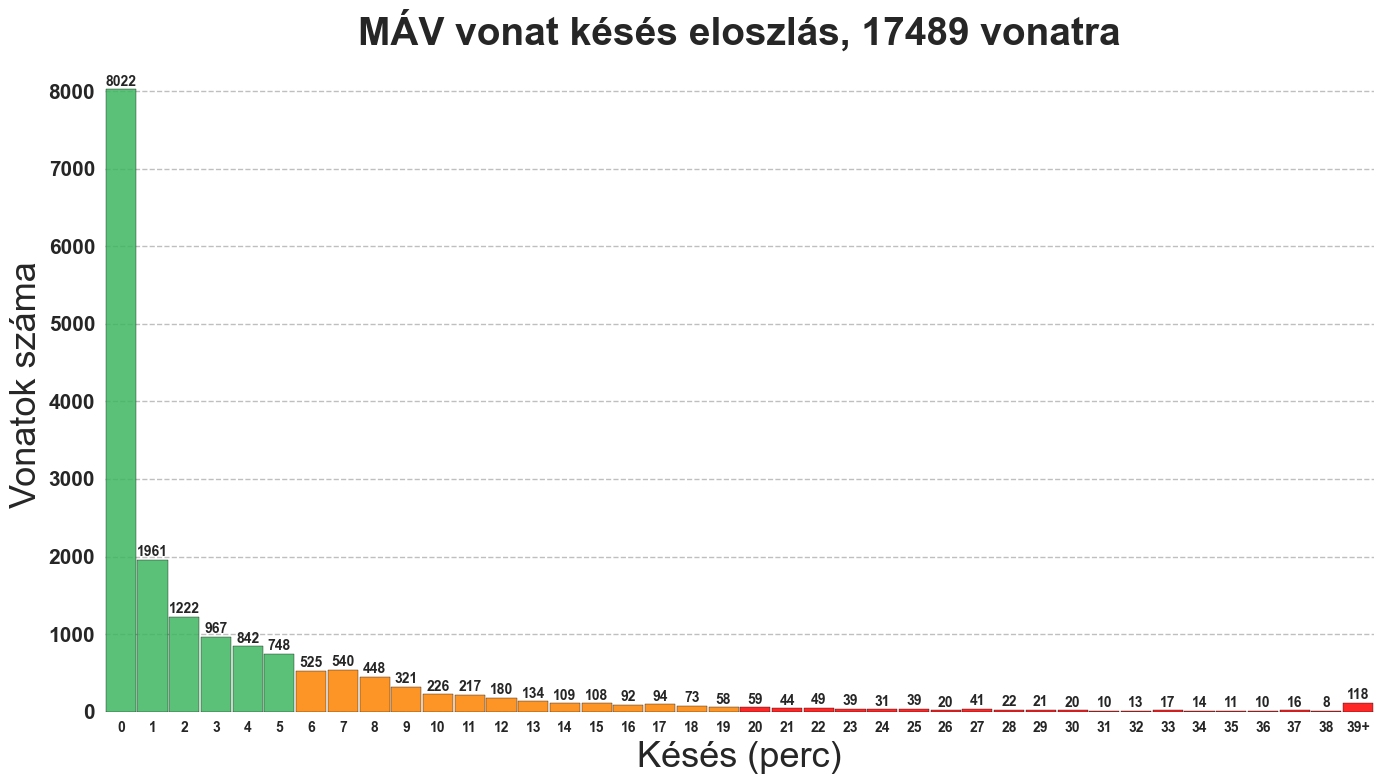

Zero-inflált negatív binomiális illesztés összefoglaló:
                    Results: ZeroInflatedNegativeBinomialP
Model:              ZeroInflatedNegativeBinomialP Pseudo R-squared: -0.000    
Dependent Variable: y                             AIC:              77225.8800
Date:               2025-07-30 19:32              BIC:              77249.1880
No. Observations:   17489                         Log-Likelihood:   -38610.   
Df Model:           0                             LL-Null:          -38610.   
Df Residuals:       17488                         LLR p-value:      nan       
Converged:          1.0000                        Scale:            1.0000    
Method:             MLE                                                       
---------------------------------------------------------------------------------
                   Coef.     Std.Err.       z        P>|z|      [0.025     0.975]
---------------------------------------------------------------------------------
inflate

In [15]:

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import lognorm, weibull_min, gamma
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP
import statsmodels.api as sm
import pandas as pd

# Késések (minden, de az utolsó binbe gyűjtjük a 40+ perceket)
delays = df_all['delay_min']
date_str = TARGET_DATE if 'TARGET_DATE' in globals() else ""

# Hisztogram plotolása (1 perces bin-ekkel, azaz min felbontás), utolsó bin: 40+
min_bin_width = 1
max_delay = 40
bins = np.arange(0, max_delay + min_bin_width, min_bin_width)  # 0,1,...,40

# Az utolsó bin a 40+ perceket is tartalmazza
delays_binned = delays[delays >= 0].copy()
delays_binned = delays_binned.apply(lambda x: x if x <= max_delay else max_delay)

fig, ax = plt.subplots(figsize=(14, 8), facecolor='white')
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

n, bins, patches = ax.hist(delays_binned, bins=bins, edgecolor='black', alpha=0.85, rwidth=0.95)

# Színezés: 0 zöld (#3EB661), 1-4 narancs (#fd8100), 5+ piros
for i, patch in enumerate(patches):
    left = bins[i]
    if left <= 5:
        patch.set_facecolor('#3EB661')
    elif left < 20 and left > 5:
        patch.set_facecolor('#fd8100')
    else:
        patch.set_facecolor('red')

# Szám kiírása minden oszlop tetejére
for rect, count in zip(patches, n):
    if count > 0:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + max(n)*0.001, 
                str(int(count)), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title(f'MÁV vonat késés eloszlás, {len(df_all)} vonatra', fontsize=28, fontweight='bold', pad=10)
ax.set_xlabel('Késés (perc)', fontsize=26)
ax.set_ylabel('Vonatok száma', fontsize=26)
ax.set_xticks(bins[:-1] + min_bin_width/2)
# Az utolsó bin felirata "40+"
ax.set_xticklabels([f"{int(left)}" for left in bins[:-1][:-1]] + [f"{int(bins[-2])}+"], fontsize=10, rotation=0, fontweight='bold')
ax.set_xlim(0, max_delay)
ax.yaxis.grid(True, linestyle='--', alpha=0.5, color='gray')
ax.set_axisbelow(True)

# Make y-ticks 50% larger and bold
yticks = ax.get_yticks()
ax.set_yticklabels([f"{int(y)}" if y == int(y) else f"{y}" for y in yticks], fontsize=15, fontweight='bold')

plt.tight_layout()

# --- STATISTICAL ANALYSIS ---

# Prepare data for fitting (all delays > 0, as lognormális nem enged 0-t)
delays_for_fit = delays[delays > 0].copy()

# 1. Lognormal fit (csak pozitív értékek!)
try:
    shape_lognorm, loc_lognorm, scale_lognorm = lognorm.fit(delays_for_fit, floc=0)
    ks_lognorm = stats.kstest(delays_for_fit, 'lognorm', args=(shape_lognorm, loc_lognorm, scale_lognorm))
    pval_lognorm = ks_lognorm.pvalue
except Exception as e:
    pval_lognorm = np.nan

# 2. Weibull fit (csak pozitív értékek!)
try:
    c_weibull, loc_weibull, scale_weibull = weibull_min.fit(delays_for_fit, floc=0)
    ks_weibull = stats.kstest(delays_for_fit, 'weibull_min', args=(c_weibull, loc_weibull, scale_weibull))
    pval_weibull = ks_weibull.pvalue
except Exception as e:
    pval_weibull = np.nan

# 3. Gamma fit (csak pozitív értékek!)
try:
    a_gamma, loc_gamma, scale_gamma = gamma.fit(delays_for_fit, floc=0)
    ks_gamma = stats.kstest(delays_for_fit, 'gamma', args=(a_gamma, loc_gamma, scale_gamma))
    pval_gamma = ks_gamma.pvalue
except Exception as e:
    pval_gamma = np.nan

# 4. Zero-inflált negatív binomiális (diszkrét, 0 is lehet)
delays_int = delays[delays >= 0].round().astype(int)
endog = delays_int.values
exog = np.ones_like(endog)
try:
    zinb_model = ZeroInflatedNegativeBinomialP(endog, exog)
    zinb_res = zinb_model.fit(disp=0)
    zinb_llf = zinb_res.llf
    zinb_p = zinb_res.pvalues[0] if hasattr(zinb_res, "pvalues") else np.nan
    zinb_summary = zinb_res.summary2().as_text()
except Exception as e:
    zinb_llf = None
    zinb_p = None
    zinb_summary = str(e)

# --- TAIL HEAVINESS ---
# Calculate tail index: proportion of delays >= 20, >= 30, >= 40, >= 50
tail_20 = (delays >= 20).mean()
tail_30 = (delays >= 30).mean()
tail_40 = (delays >= 40).mean()
tail_50 = (delays >= 50).mean()
max_delay_val = delays.max()

# --- P-VALUES BOX ---
box_text = (
    f"Lognormális p: {pval_lognorm:.3g}\n"
    f"Weibull p: {pval_weibull:.3g}\n"
    f"Gamma p: {pval_gamma:.3g}\n"
    f"Zero-inflált NB loglik: {zinb_llf:.1f}\n"
    f"Farok (20+): {tail_20:.1%}\n"
    f"Farok (30+): {tail_30:.1%}\n"
    f"Farok (40+): {tail_40:.1%}\n"
    f"Farok (50+): {tail_50:.1%}\n"
    f"Max késés: {max_delay_val:.0f} perc"
)

# Save the current figure as SVG before showing
plt.gcf().savefig("plots/delay_distribution_pvalues.svg", format="svg")
plt.show()

# Optional: print ZINB summary for notebook inspection
print("Zero-inflált negatív binomiális illesztés összefoglaló:")
print(zinb_summary)


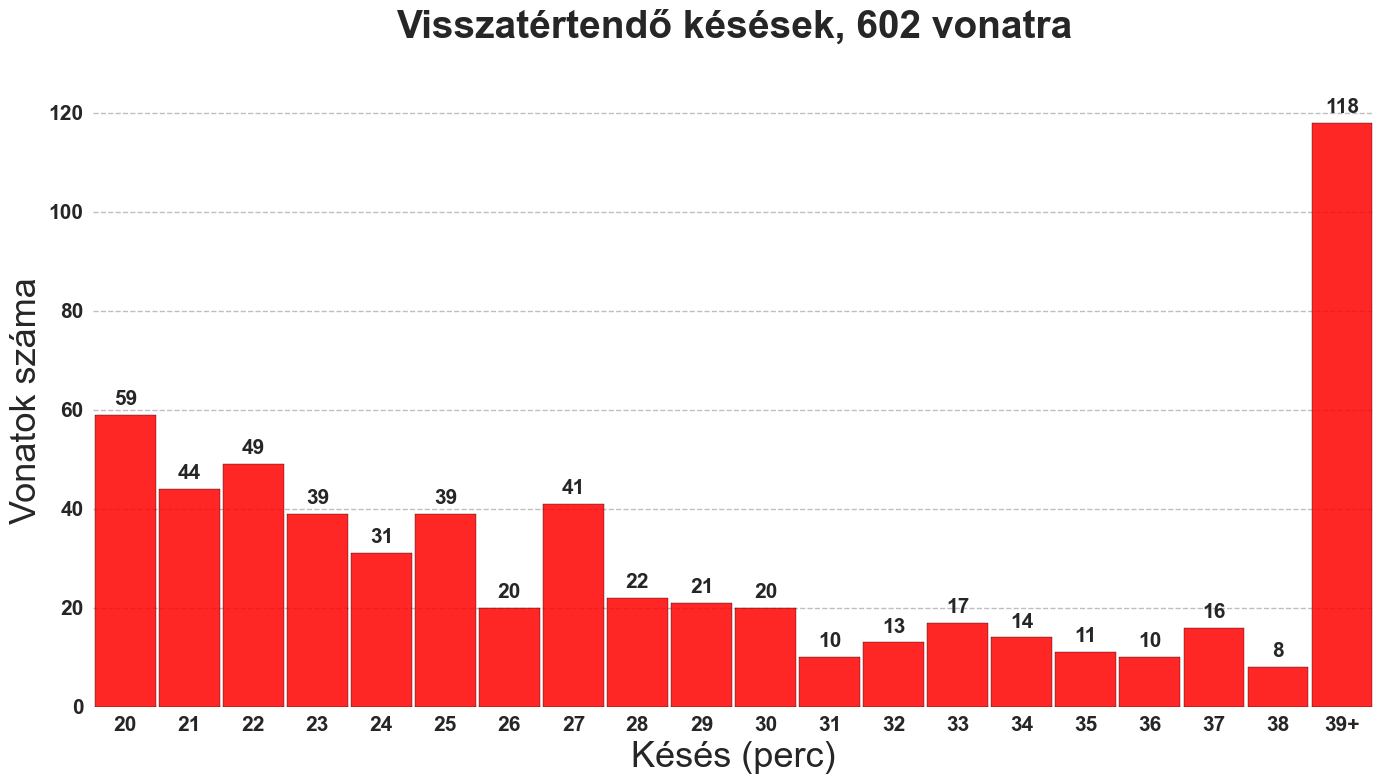

In [16]:

import numpy as np

# Csak a legalább 20 percet késett vonatok (20 vagy több)
delays = df_all['delay_min']
date_str = TARGET_DATE if 'TARGET_DATE' in globals() else ""

# Csak a 20 vagy több percet késett vonatok
min_bin_width = 1
min_delay = 20
max_delay = 40
bins = np.arange(min_delay, max_delay + min_bin_width, min_bin_width)  # 20,21,...,40

# Az utolsó bin a 40+ perceket is tartalmazza
delays_binned = delays[delays >= min_delay].copy()
delays_binned = delays_binned.apply(lambda x: x if x <= max_delay else max_delay)

fig, ax = plt.subplots(figsize=(14, 8), facecolor='white')
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

n, bins, patches = ax.hist(delays_binned, bins=bins, edgecolor='black', alpha=0.85, rwidth=0.95)

# Színezés: minden bin piros (mert mind >=20)
for patch in patches:
    patch.set_facecolor('red')

# Szám kiírása minden oszlop tetejére
for rect, count in zip(patches, n):
    if count > 0:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + max(n)*0.01, 
                str(int(count)), ha='center', va='bottom', fontsize=15, fontweight='bold')

plt.title(f'Visszatértendő késések, {len(delays_binned)} vonatra', fontsize=28, fontweight='bold', pad=40)
ax.set_xlabel('Késés (perc)', fontsize=26)
ax.set_ylabel('Vonatok száma', fontsize=26)
ax.set_xticks(bins[:-1] + min_bin_width/2)
# Az utolsó bin felirata "40+"
ax.set_xticklabels([f"{int(left)}" for left in bins[:-1][:-1]] + [f"{int(bins[-2])}+"], fontsize=15, rotation=0, fontweight='bold')
ax.set_xlim(min_delay, max_delay)
ax.yaxis.grid(True, linestyle='--', alpha=0.5, color='gray')
ax.set_axisbelow(True)

# Make y-ticks 50% larger and bold
yticks = ax.get_yticks()
ax.set_yticklabels([f"{int(y)}" if y == int(y) else f"{y}" for y in yticks], fontsize=15, fontweight='bold')

plt.tight_layout()
plt.gcf().savefig("plots/refundable.svg", format="svg")
plt.show()


In [18]:
# prices.min()

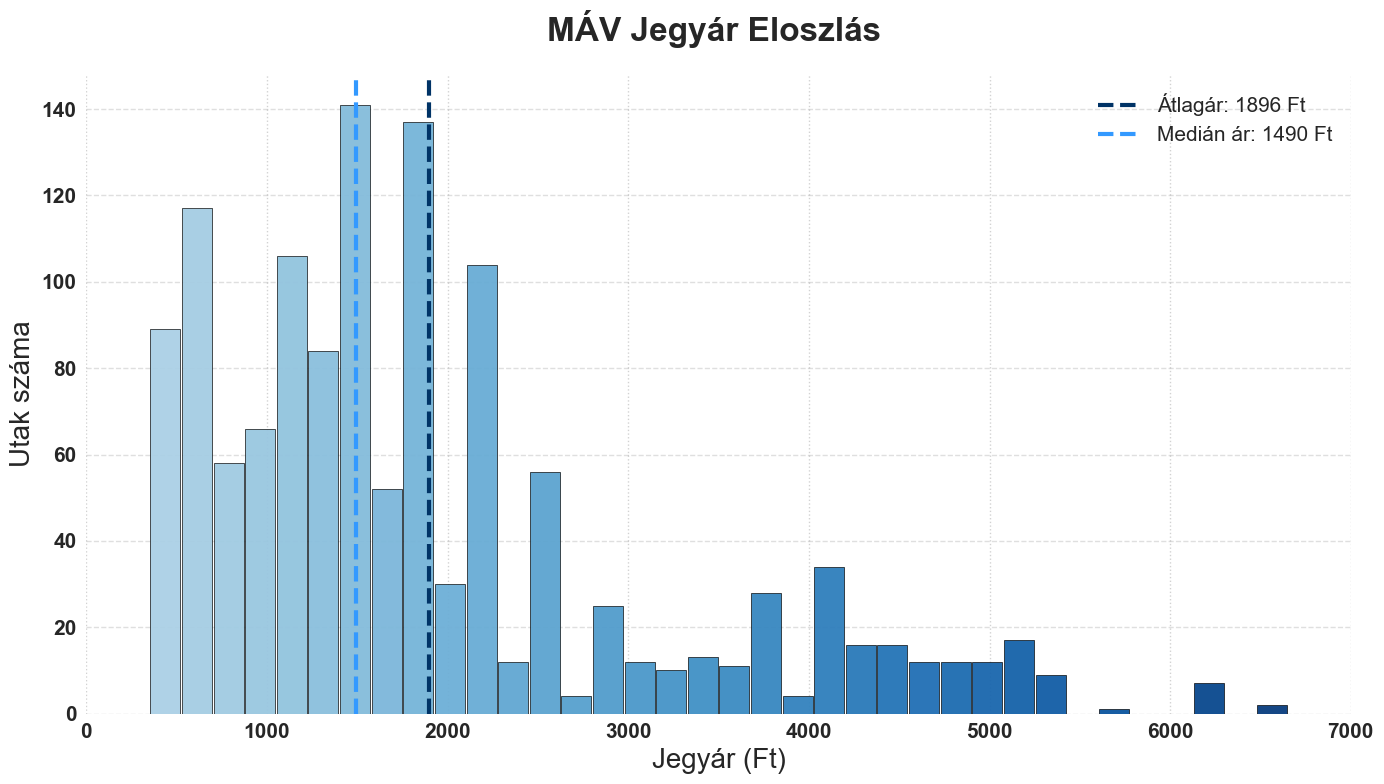

In [31]:

# --- MÁV Jegyár Eloszlás hisztogram (szép, letisztult, magyar feliratokkal) ---

import matplotlib as mpl
from matplotlib.colors import Normalize

prices = df_clean.loc[df_clean['price_huf'] > 0, 'price_huf']

free_routes = (prices == 0).sum()
paid_routes = prices[prices > 0]

fig, ax = plt.subplots(figsize=(14, 8), facecolor='white')
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Bin-ek: 0-tól 7000-ig, 175 Ft-os lépésközzel (40 bin)
bins = np.linspace(0, 7000, 41)
n, bins, patches = ax.hist(prices, bins=bins, alpha=0.95, edgecolor='black', linewidth=0.5, rwidth=0.95)

# Kék színskála az oszlopokra
norm = Normalize(vmin=bins[0], vmax=bins[-1])
cmap = mpl.cm.Blues
for patch, left in zip(patches, bins[:-1]):
    color = cmap(0.3 + 0.7 * norm(left))  # 0.3-tól 1.0-ig, hogy jól látszódjon a különbség
    patch.set_facecolor(color)

# Függőleges vonalak: átlag, medián, ingyenes
ax.axvline(prices.mean(), color='#003366', linestyle='--', linewidth=3, 
           label=f'Átlagár: {prices.mean():.0f} Ft')
ax.axvline(prices.median(), color='#3399ff', linestyle='--', linewidth=3, 
           label=f'Medián ár: {prices.median():.0f} Ft')

# Rácsvonalak
ax.xaxis.grid(True, which='major', linestyle=':', color='gray', alpha=0.35)
ax.yaxis.grid(True, which='major', linestyle='--', color='gray', alpha=0.25)
ax.set_axisbelow(True)

# Tengelyek, címek, jelmagyarázat
ax.set_title('MÁV Jegyár Eloszlás ', fontsize=24, fontweight='bold', pad=24)
ax.set_xlabel('Jegyár (Ft)', fontsize=20)
ax.set_ylabel('Utak száma', fontsize=20)
ax.legend(fontsize=15)

# X-tickek 50%-kal nagyobb, félkövér betűvel
xticks = ax.get_xticks()
# Csak a 0 vagy nagyobb értékű tickeket jelenítjük meg, hogy ne legyen -1000
xticks = [x for x in xticks if x >= 0]
ax.set_xticks(xticks)
ax.set_xticklabels([f"{int(x)}" if x == int(x) else f"{x}" for x in xticks], fontsize=15, fontweight='bold')

ax.set_xlim(0, 7000)

# Y-tickek nagyobb, félkövér betűvel
yticks = ax.get_yticks()
ax.set_yticklabels([f"{int(y)}" if y == int(y) else f"{y}" for y in yticks], fontsize=15, fontweight='bold')

plt.tight_layout()
fig.savefig("plots/mav_jegyar_eloszlas.svg", format="svg")
plt.show()

In [20]:
import scipy.stats as st
# count 18&19 vs 20&21
left  = delays.isin([18, 19]).sum()
right = delays.isin([20, 21]).sum()
ratio = left / right if right else np.inf
p     = st.binom_test(left, left+right, p=.5, alternative="greater")

print(f"18–19 min: {left}, 20–21 min: {right}")
print(f"ratio = {ratio:.2f},  p = {p:.4f}")


18–19 min: 131, 20–21 min: 103
ratio = 1.27,  p = 0.0387


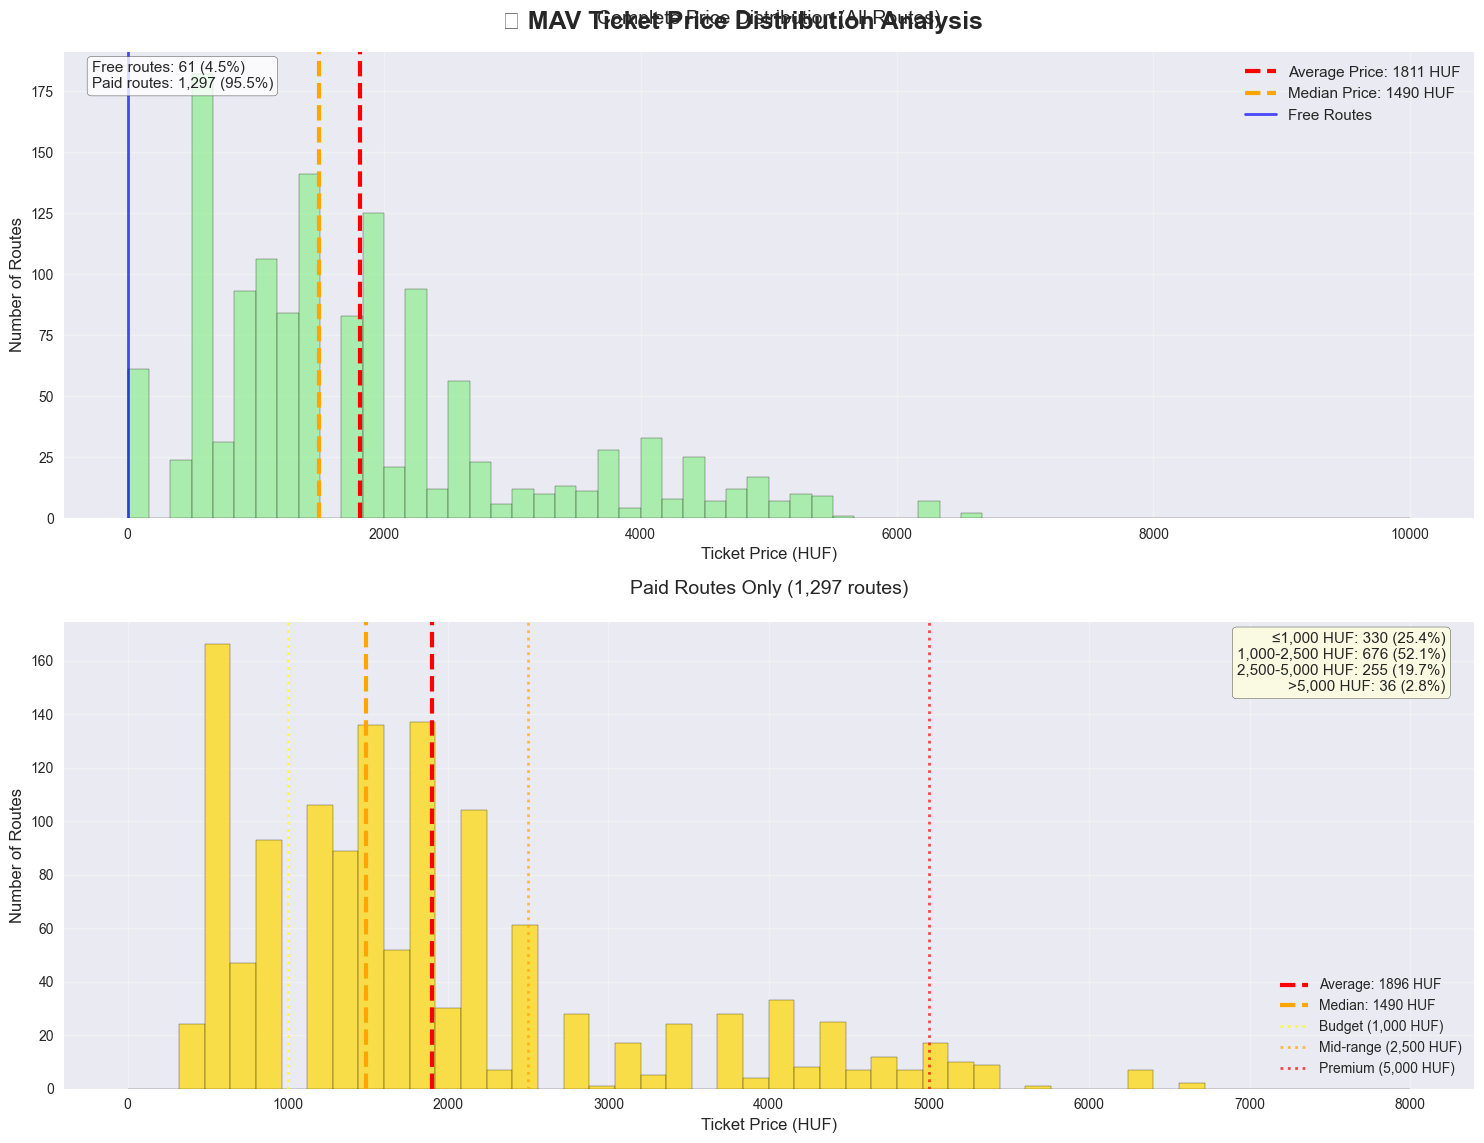


💰 PRICE ANALYSIS SUMMARY:
   🆓 Free routes: 61 (4.5%)
   💵 Paid routes: 1,297 (95.5%)
   📊 Cheapest paid ticket: 400 HUF
   📊 Most expensive ticket: 6580 HUF
   📈 Average price (paid routes): 1896 HUF
   📈 Median price (paid routes): 1490 HUF
   ⚡ Average price efficiency: 19.4 HUF per minute
   💸 Budget routes (≤1,000 HUF): 330 (25.4%)
   💳 Premium routes (>2,500 HUF): 291 (22.4%)


In [22]:


# Create a focused price histogram
fig, axes = plt.subplots(2, 1, figsize=(15, 12))
fig.suptitle('💰 MAV Ticket Price Distribution Analysis', fontsize=18, fontweight='bold', y=0.95)

# 1. Overall price distribution (including free routes)
prices = df_clean['price_huf']
all_prices = prices.copy()

# Split into free and paid routes
free_routes = (prices == 0).sum()
paid_routes = prices[prices > 0]

# Plot all prices (including 0)
axes[0].hist(prices, bins=60, alpha=0.7, color='lightgreen', edgecolor='black', range=(0, 10000))
axes[0].axvline(prices.mean(), color='red', linestyle='--', linewidth=3, 
               label=f'Average Price: {prices.mean():.0f} HUF')
axes[0].axvline(prices.median(), color='orange', linestyle='--', linewidth=3, 
               label=f'Median Price: {prices.median():.0f} HUF')
axes[0].axvline(0, color='blue', linestyle='-', linewidth=2, alpha=0.7, label='Free Routes')
axes[0].set_title('Complete Price Distribution (All Routes)', fontsize=14, pad=20)
axes[0].set_xlabel('Ticket Price (HUF)', fontsize=12)
axes[0].set_ylabel('Number of Routes', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Add text annotations for free vs paid
axes[0].text(0.02, 0.98, f'Free routes: {free_routes:,} ({free_routes/len(prices)*100:.1f}%)\nPaid routes: {len(paid_routes):,} ({len(paid_routes)/len(prices)*100:.1f}%)', 
            transform=axes[0].transAxes, fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Focus on paid routes only
if len(paid_routes) > 0:
    axes[1].hist(paid_routes, bins=50, alpha=0.7, color='gold', edgecolor='black', range=(0, 8000))
    axes[1].axvline(paid_routes.mean(), color='red', linestyle='--', linewidth=3, 
                   label=f'Average: {paid_routes.mean():.0f} HUF')
    axes[1].axvline(paid_routes.median(), color='orange', linestyle='--', linewidth=3, 
                   label=f'Median: {paid_routes.median():.0f} HUF')
    
    # Add price category markers
    axes[1].axvline(1000, color='yellow', linestyle=':', linewidth=2, alpha=0.7, label='Budget (1,000 HUF)')
    axes[1].axvline(2500, color='orange', linestyle=':', linewidth=2, alpha=0.7, label='Mid-range (2,500 HUF)')
    axes[1].axvline(5000, color='red', linestyle=':', linewidth=2, alpha=0.7, label='Premium (5,000 HUF)')
    
    axes[1].set_title(f'Paid Routes Only ({len(paid_routes):,} routes)', fontsize=14, pad=20)
    axes[1].set_xlabel('Ticket Price (HUF)', fontsize=12)
    axes[1].set_ylabel('Number of Routes', fontsize=12)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    # Add price categories
    budget = (paid_routes <= 1000).sum()
    mid_range = ((paid_routes > 1000) & (paid_routes <= 2500)).sum()
    premium = ((paid_routes > 2500) & (paid_routes <= 5000)).sum()
    luxury = (paid_routes > 5000).sum()
    
    axes[1].text(0.98, 0.98, f'≤1,000 HUF: {budget:,} ({budget/len(paid_routes)*100:.1f}%)\n1,000-2,500 HUF: {mid_range:,} ({mid_range/len(paid_routes)*100:.1f}%)\n2,500-5,000 HUF: {premium:,} ({premium/len(paid_routes)*100:.1f}%)\n>5,000 HUF: {luxury:,} ({luxury/len(paid_routes)*100:.1f}%)', 
             transform=axes[1].transAxes, fontsize=11, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

# Calculate price efficiency (price per minute for paid routes)
if len(paid_routes) > 0:
    paid_df = df_clean[df_clean['price_huf'] > 0]
    price_per_min = paid_df['price_huf'] / paid_df['travel_time_minutes']
    price_per_min_clean = price_per_min[price_per_min < 50]  # Remove outliers

# Print comprehensive price statistics
print("\n💰 PRICE ANALYSIS SUMMARY:")
print(f"   🆓 Free routes: {free_routes:,} ({free_routes/len(prices)*100:.1f}%)")
print(f"   💵 Paid routes: {len(paid_routes):,} ({len(paid_routes)/len(prices)*100:.1f}%)")
print(f"   📊 Cheapest paid ticket: {paid_routes.min():.0f} HUF")
print(f"   📊 Most expensive ticket: {paid_routes.max():.0f} HUF")
print(f"   📈 Average price (paid routes): {paid_routes.mean():.0f} HUF")
print(f"   📈 Median price (paid routes): {paid_routes.median():.0f} HUF")
if len(paid_routes) > 0:
    print(f"   ⚡ Average price efficiency: {price_per_min_clean.mean():.1f} HUF per minute")
    print(f"   💸 Budget routes (≤1,000 HUF): {budget:,} ({budget/len(paid_routes)*100:.1f}%)")
    print(f"   💳 Premium routes (>2,500 HUF): {premium + luxury:,} ({(premium + luxury)/len(paid_routes)*100:.1f}%)")



💰 TICKET PRICE ANALYSIS


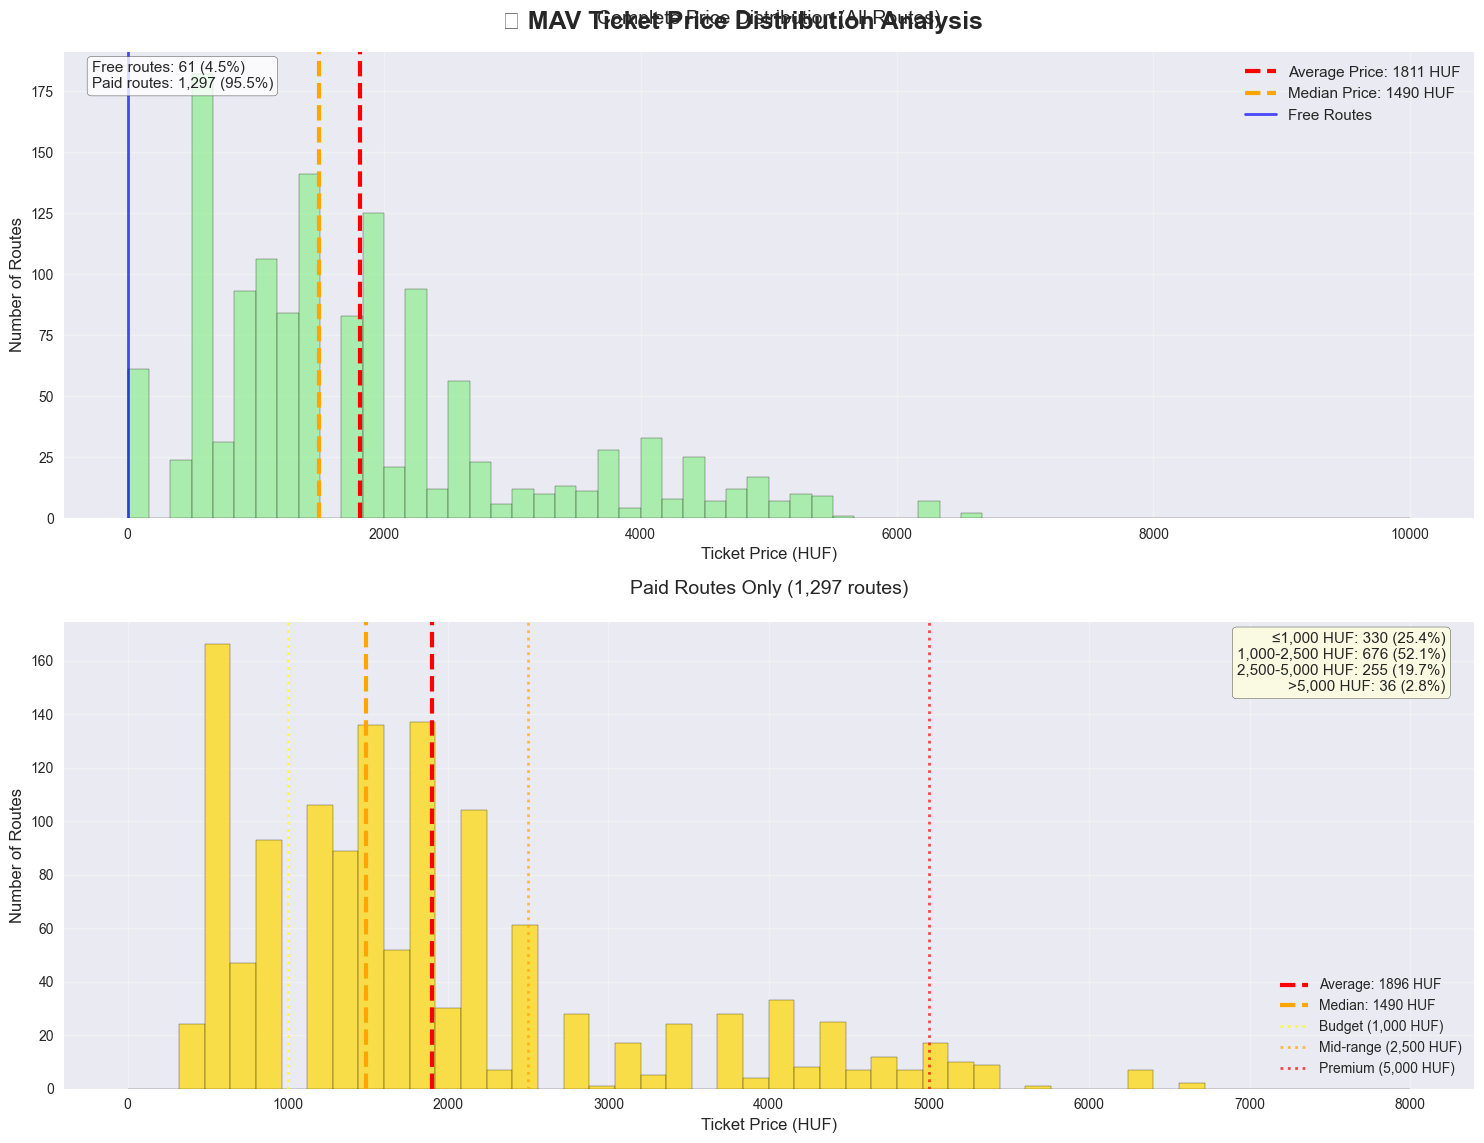


💰 PRICE ANALYSIS SUMMARY:
   🆓 Free routes: 61 (4.5%)
   💵 Paid routes: 1,297 (95.5%)
   📊 Cheapest paid ticket: 400 HUF
   📊 Most expensive ticket: 6580 HUF
   📈 Average price (paid routes): 1896 HUF
   📈 Median price (paid routes): 1490 HUF
   ⚡ Average price efficiency: 19.4 HUF per minute
   💸 Budget routes (≤1,000 HUF): 330 (25.4%)
   💳 Premium routes (>2,500 HUF): 291 (22.4%)


In [23]:
# 📊 HISTOGRAM 2: How Much Do MAV Tickets Cost? (Price Analysis)

print("\n" + "="*60)
print("💰 TICKET PRICE ANALYSIS")
print("="*60)

# Create a focused price histogram
fig, axes = plt.subplots(2, 1, figsize=(15, 12))
fig.suptitle('💰 MAV Ticket Price Distribution Analysis', fontsize=18, fontweight='bold', y=0.95)

# 1. Overall price distribution (including free routes)
prices = df_clean['price_huf']
all_prices = prices.copy()

# Split into free and paid routes
free_routes = (prices == 0).sum()
paid_routes = prices[prices > 0]

# Plot all prices (including 0)
axes[0].hist(prices, bins=60, alpha=0.7, color='lightgreen', edgecolor='black', range=(0, 10000))
axes[0].axvline(prices.mean(), color='red', linestyle='--', linewidth=3, 
               label=f'Average Price: {prices.mean():.0f} HUF')
axes[0].axvline(prices.median(), color='orange', linestyle='--', linewidth=3, 
               label=f'Median Price: {prices.median():.0f} HUF')
axes[0].axvline(0, color='blue', linestyle='-', linewidth=2, alpha=0.7, label='Free Routes')
axes[0].set_title('Complete Price Distribution (All Routes)', fontsize=14, pad=20)
axes[0].set_xlabel('Ticket Price (HUF)', fontsize=12)
axes[0].set_ylabel('Number of Routes', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Add text annotations for free vs paid
axes[0].text(0.02, 0.98, f'Free routes: {free_routes:,} ({free_routes/len(prices)*100:.1f}%)\nPaid routes: {len(paid_routes):,} ({len(paid_routes)/len(prices)*100:.1f}%)', 
            transform=axes[0].transAxes, fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Focus on paid routes only
if len(paid_routes) > 0:
    axes[1].hist(paid_routes, bins=50, alpha=0.7, color='gold', edgecolor='black', range=(0, 8000))
    axes[1].axvline(paid_routes.mean(), color='red', linestyle='--', linewidth=3, 
                   label=f'Average: {paid_routes.mean():.0f} HUF')
    axes[1].axvline(paid_routes.median(), color='orange', linestyle='--', linewidth=3, 
                   label=f'Median: {paid_routes.median():.0f} HUF')
    
    # Add price category markers
    axes[1].axvline(1000, color='yellow', linestyle=':', linewidth=2, alpha=0.7, label='Budget (1,000 HUF)')
    axes[1].axvline(2500, color='orange', linestyle=':', linewidth=2, alpha=0.7, label='Mid-range (2,500 HUF)')
    axes[1].axvline(5000, color='red', linestyle=':', linewidth=2, alpha=0.7, label='Premium (5,000 HUF)')
    
    axes[1].set_title(f'Paid Routes Only ({len(paid_routes):,} routes)', fontsize=14, pad=20)
    axes[1].set_xlabel('Ticket Price (HUF)', fontsize=12)
    axes[1].set_ylabel('Number of Routes', fontsize=12)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    # Add price categories
    budget = (paid_routes <= 1000).sum()
    mid_range = ((paid_routes > 1000) & (paid_routes <= 2500)).sum()
    premium = ((paid_routes > 2500) & (paid_routes <= 5000)).sum()
    luxury = (paid_routes > 5000).sum()
    
    axes[1].text(0.98, 0.98, f'≤1,000 HUF: {budget:,} ({budget/len(paid_routes)*100:.1f}%)\n1,000-2,500 HUF: {mid_range:,} ({mid_range/len(paid_routes)*100:.1f}%)\n2,500-5,000 HUF: {premium:,} ({premium/len(paid_routes)*100:.1f}%)\n>5,000 HUF: {luxury:,} ({luxury/len(paid_routes)*100:.1f}%)', 
             transform=axes[1].transAxes, fontsize=11, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

# Calculate price efficiency (price per minute for paid routes)
if len(paid_routes) > 0:
    paid_df = df_clean[df_clean['price_huf'] > 0]
    price_per_min = paid_df['price_huf'] / paid_df['travel_time_minutes']
    price_per_min_clean = price_per_min[price_per_min < 50]  # Remove outliers

# Print comprehensive price statistics
print("\n💰 PRICE ANALYSIS SUMMARY:")
print(f"   🆓 Free routes: {free_routes:,} ({free_routes/len(prices)*100:.1f}%)")
print(f"   💵 Paid routes: {len(paid_routes):,} ({len(paid_routes)/len(prices)*100:.1f}%)")
print(f"   📊 Cheapest paid ticket: {paid_routes.min():.0f} HUF")
print(f"   📊 Most expensive ticket: {paid_routes.max():.0f} HUF")
print(f"   📈 Average price (paid routes): {paid_routes.mean():.0f} HUF")
print(f"   📈 Median price (paid routes): {paid_routes.median():.0f} HUF")
if len(paid_routes) > 0:
    print(f"   ⚡ Average price efficiency: {price_per_min_clean.mean():.1f} HUF per minute")
    print(f"   💸 Budget routes (≤1,000 HUF): {budget:,} ({budget/len(paid_routes)*100:.1f}%)")
    print(f"   💳 Premium routes (>2,500 HUF): {premium + luxury:,} ({(premium + luxury)/len(paid_routes)*100:.1f}%)")



💰 TICKET PRICE ANALYSIS


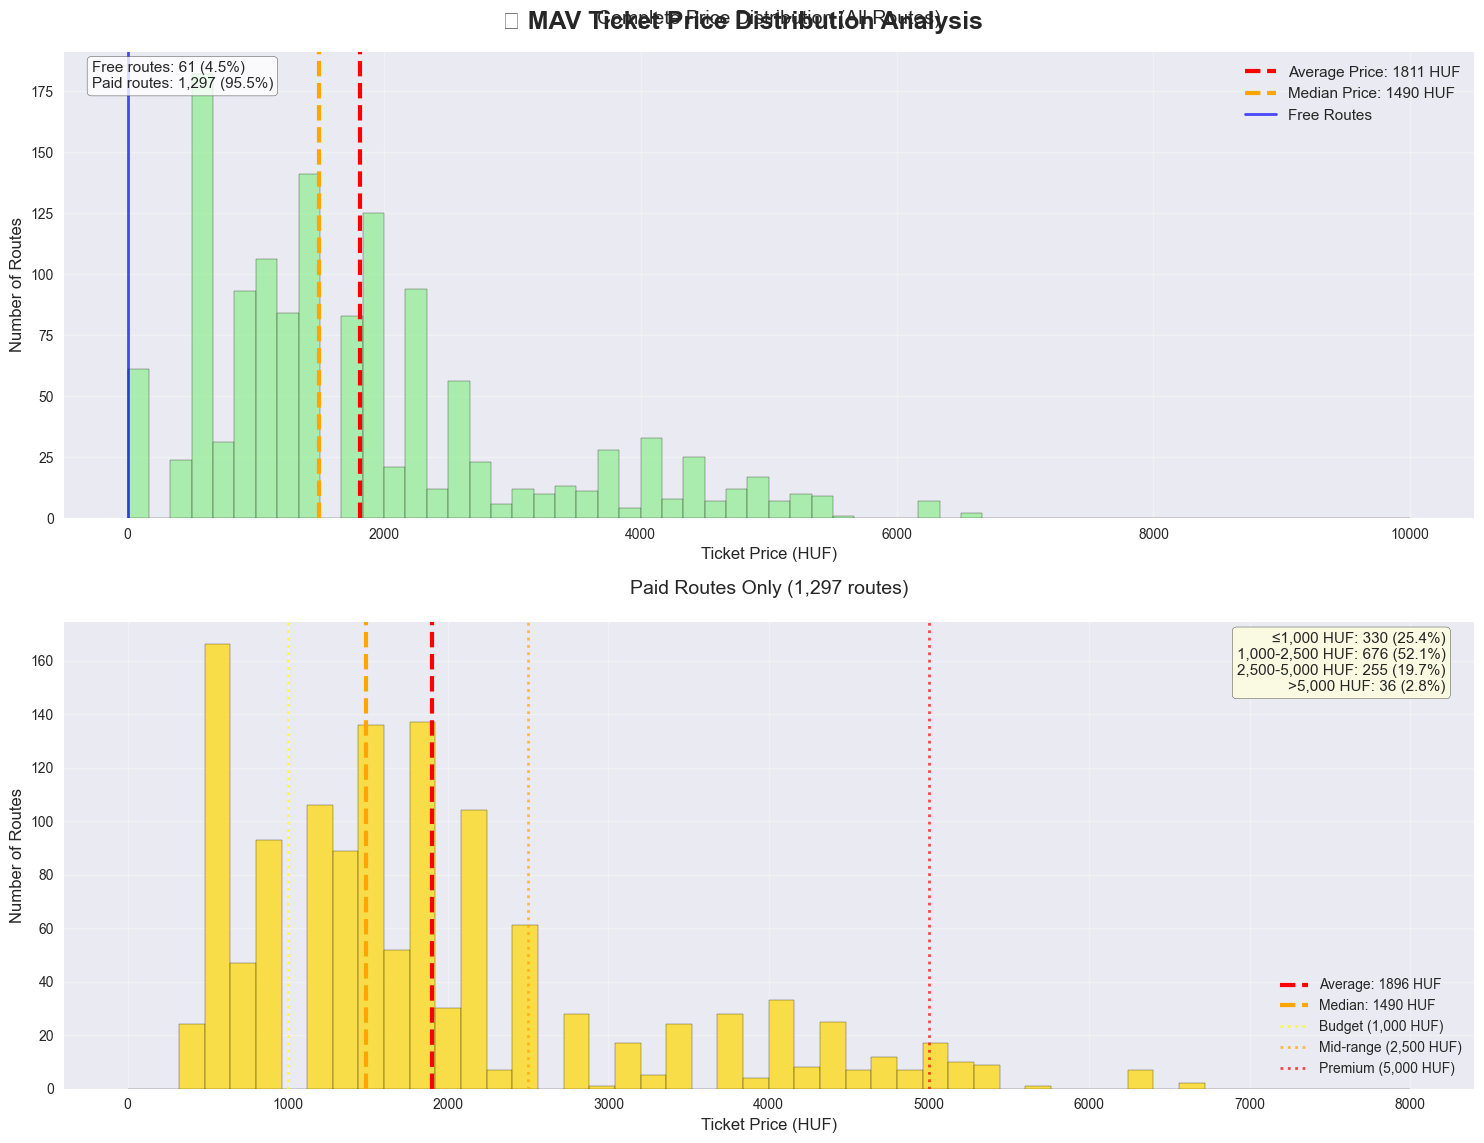


💰 PRICE ANALYSIS SUMMARY:
   🆓 Free routes: 61 (4.5%)
   💵 Paid routes: 1,297 (95.5%)
   📊 Cheapest paid ticket: 400 HUF
   📊 Most expensive ticket: 6580 HUF
   📈 Average price (paid routes): 1896 HUF
   📈 Median price (paid routes): 1490 HUF
   ⚡ Average price efficiency: 19.4 HUF per minute
   💸 Budget routes (≤1,000 HUF): 330 (25.4%)
   💳 Premium routes (>2,500 HUF): 291 (22.4%)


In [24]:
# 📊 HISTOGRAM 2: How Much Do MAV Tickets Cost? (Price Analysis)

print("\n" + "="*60)
print("💰 TICKET PRICE ANALYSIS")
print("="*60)

# Create a focused price histogram
fig, axes = plt.subplots(2, 1, figsize=(15, 12))
fig.suptitle('💰 MAV Ticket Price Distribution Analysis', fontsize=18, fontweight='bold', y=0.95)

# 1. Overall price distribution (including free routes)
prices = df_clean['price_huf']
all_prices = prices.copy()

# Split into free and paid routes
free_routes = (prices == 0).sum()
paid_routes = prices[prices > 0]

# Plot all prices (including 0)
axes[0].hist(prices, bins=60, alpha=0.7, color='lightgreen', edgecolor='black', range=(0, 10000))
axes[0].axvline(prices.mean(), color='red', linestyle='--', linewidth=3, 
               label=f'Average Price: {prices.mean():.0f} HUF')
axes[0].axvline(prices.median(), color='orange', linestyle='--', linewidth=3, 
               label=f'Median Price: {prices.median():.0f} HUF')
axes[0].axvline(0, color='blue', linestyle='-', linewidth=2, alpha=0.7, label='Free Routes')
axes[0].set_title('Complete Price Distribution (All Routes)', fontsize=14, pad=20)
axes[0].set_xlabel('Ticket Price (HUF)', fontsize=12)
axes[0].set_ylabel('Number of Routes', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Add text annotations for free vs paid
axes[0].text(0.02, 0.98, f'Free routes: {free_routes:,} ({free_routes/len(prices)*100:.1f}%)\nPaid routes: {len(paid_routes):,} ({len(paid_routes)/len(prices)*100:.1f}%)', 
            transform=axes[0].transAxes, fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Focus on paid routes only
if len(paid_routes) > 0:
    axes[1].hist(paid_routes, bins=50, alpha=0.7, color='gold', edgecolor='black', range=(0, 8000))
    axes[1].axvline(paid_routes.mean(), color='red', linestyle='--', linewidth=3, 
                   label=f'Average: {paid_routes.mean():.0f} HUF')
    axes[1].axvline(paid_routes.median(), color='orange', linestyle='--', linewidth=3, 
                   label=f'Median: {paid_routes.median():.0f} HUF')
    
    # Add price category markers
    axes[1].axvline(1000, color='yellow', linestyle=':', linewidth=2, alpha=0.7, label='Budget (1,000 HUF)')
    axes[1].axvline(2500, color='orange', linestyle=':', linewidth=2, alpha=0.7, label='Mid-range (2,500 HUF)')
    axes[1].axvline(5000, color='red', linestyle=':', linewidth=2, alpha=0.7, label='Premium (5,000 HUF)')
    
    axes[1].set_title(f'Paid Routes Only ({len(paid_routes):,} routes)', fontsize=14, pad=20)
    axes[1].set_xlabel('Ticket Price (HUF)', fontsize=12)
    axes[1].set_ylabel('Number of Routes', fontsize=12)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    # Add price categories
    budget = (paid_routes <= 1000).sum()
    mid_range = ((paid_routes > 1000) & (paid_routes <= 2500)).sum()
    premium = ((paid_routes > 2500) & (paid_routes <= 5000)).sum()
    luxury = (paid_routes > 5000).sum()
    
    axes[1].text(0.98, 0.98, f'≤1,000 HUF: {budget:,} ({budget/len(paid_routes)*100:.1f}%)\n1,000-2,500 HUF: {mid_range:,} ({mid_range/len(paid_routes)*100:.1f}%)\n2,500-5,000 HUF: {premium:,} ({premium/len(paid_routes)*100:.1f}%)\n>5,000 HUF: {luxury:,} ({luxury/len(paid_routes)*100:.1f}%)', 
             transform=axes[1].transAxes, fontsize=11, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

# Calculate price efficiency (price per minute for paid routes)
if len(paid_routes) > 0:
    paid_df = df_clean[df_clean['price_huf'] > 0]
    price_per_min = paid_df['price_huf'] / paid_df['travel_time_minutes']
    price_per_min_clean = price_per_min[price_per_min < 50]  # Remove outliers

# Print comprehensive price statistics
print("\n💰 PRICE ANALYSIS SUMMARY:")
print(f"   🆓 Free routes: {free_routes:,} ({free_routes/len(prices)*100:.1f}%)")
print(f"   💵 Paid routes: {len(paid_routes):,} ({len(paid_routes)/len(prices)*100:.1f}%)")
print(f"   📊 Cheapest paid ticket: {paid_routes.min():.0f} HUF")
print(f"   📊 Most expensive ticket: {paid_routes.max():.0f} HUF")
print(f"   📈 Average price (paid routes): {paid_routes.mean():.0f} HUF")
print(f"   📈 Median price (paid routes): {paid_routes.median():.0f} HUF")
if len(paid_routes) > 0:
    print(f"   ⚡ Average price efficiency: {price_per_min_clean.mean():.1f} HUF per minute")
    print(f"   💸 Budget routes (≤1,000 HUF): {budget:,} ({budget/len(paid_routes)*100:.1f}%)")
    print(f"   💳 Premium routes (>2,500 HUF): {premium + luxury:,} ({(premium + luxury)/len(paid_routes)*100:.1f}%)")


In [25]:
# 📊 Summary Dashboard

print("\n" + "="*80)
print("🚆 MAV ROUTE ANALYSIS SUMMARY DASHBOARD")
print("="*80)
print(f"📅 Analysis Date: {TARGET_DATE} (actual data: {df_clean['date'].iloc[0]})")
print(f"📊 Total Routes Analyzed: {len(df_clean):,}")
print(f"🚉 Unique Station Pairs: {df_clean['station_pair'].nunique():,}")
print("")

print("🕐 DELAY PERFORMANCE:")
on_time_pct = (df_clean['delay_min'] == 0).mean() * 100
delayed_pct = (df_clean['delay_min'] > 0).mean() * 100
sig_delayed_pct = (df_clean['delay_min'] > 10).mean() * 100
print(f"   ✅ On-time: {on_time_pct:.1f}%")
print(f"   ⚠️  Delayed: {delayed_pct:.1f}%")
print(f"   🔴 Significantly delayed (>10min): {sig_delayed_pct:.1f}%")
print(f"   📈 Average delay: {df_clean['delay_min'].mean():.1f} minutes")
print(f"   📈 Maximum delay: {df_clean['delay_min'].max():.0f} minutes")
print("")

print("💰 PRICING INSIGHTS:")
paid_routes_summary = df_clean[df_clean['price_huf'] > 0]
free_pct = (df_clean['price_huf'] == 0).mean() * 100
print(f"   🆓 Free routes: {free_pct:.1f}%")
print(f"   💵 Average ticket price: {paid_routes_summary['price_huf'].mean():.0f} HUF")
print(f"   💎 Most expensive route: {df_clean['price_huf'].max():.0f} HUF")
price_per_min_summary = paid_routes_summary['price_huf'] / paid_routes_summary['travel_time_minutes']
print(f"   ⚡ Price efficiency: {price_per_min_summary.mean():.1f} HUF per minute")
print("")

print("🚄 TRAVEL PATTERNS:")
print(f"   ⏱️  Average travel time: {df_clean['travel_time_minutes'].mean():.0f} minutes ({df_clean['travel_time_minutes'].mean()/60:.1f} hours)")
print(f"   🚀 Shortest route: {df_clean['travel_time_minutes'].min():.0f} minutes")
print(f"   🐌 Longest route: {df_clean['travel_time_minutes'].max():.0f} minutes ({df_clean['travel_time_minutes'].max()/60:.1f} hours)")
print(f"   🔄 Average transfers: {df_clean['transfers_count'].mean():.1f}")
print("")

print("🚉 POPULAR DESTINATIONS:")
top_start = df_clean['start_station'].value_counts().head(3)
top_end = df_clean['end_station'].value_counts().head(3)
print(f"   🏁 Top start stations: {', '.join([f'{station[:10]}({count})' for station, count in top_start.items()])}")
print(f"   🏁 Top end stations: {', '.join([f'{station[:10]}({count})' for station, count in top_end.items()])}")
print("")

print("="*80)
print("🎯 Analysis complete! Data sourced from Google Cloud Storage.")
print(f"📊 Focused on delay and price histograms for {TARGET_DATE}")
print("="*80)



🚆 MAV ROUTE ANALYSIS SUMMARY DASHBOARD
📅 Analysis Date: 2025-07-24 (actual data: 2025-07-24)
📊 Total Routes Analyzed: 1,358
🚉 Unique Station Pairs: 125

🕐 DELAY PERFORMANCE:
   ✅ On-time: 47.4%
   ⚠️  Delayed: 52.6%
   🔴 Significantly delayed (>10min): 10.4%
   📈 Average delay: 3.5 minutes
   📈 Maximum delay: 48 minutes

💰 PRICING INSIGHTS:
   🆓 Free routes: 4.5%
   💵 Average ticket price: 1896 HUF
   💎 Most expensive route: 6580 HUF
   ⚡ Price efficiency: 19.7 HUF per minute

🚄 TRAVEL PATTERNS:
   ⏱️  Average travel time: 101 minutes (1.7 hours)
   🚀 Shortest route: 14 minutes
   🐌 Longest route: 292 minutes (4.9 hours)
   🔄 Average transfers: 0.6

🚉 POPULAR DESTINATIONS:
   🏁 Top start stations: 005513748(102), 005510009(78), 004302246(66)
   🏁 Top end stations: 005510009(228), 005517111(91), 005513748(78)

🎯 Analysis complete! Data sourced from Google Cloud Storage.
📊 Focused on delay and price histograms for 2025-07-24


In [26]:
# 📊 LATE TRAINS ANALYSIS (20+ Minutes Delay)

print("\n" + "="*60)
print("🔴 LATE TRAINS ANALYSIS (20+ MINUTES DELAY)")
print("="*60)

# Define late trains as 20+ minutes delay
LATE_THRESHOLD = 20
late_trains = df_clean[df_clean['delay_min'] >= LATE_THRESHOLD]
on_time_trains = df_clean[df_clean['delay_min'] < LATE_THRESHOLD]

print(f"🎯 Late Train Definition: {LATE_THRESHOLD}+ minutes delay")
print(f"📊 Total trains analyzed: {len(df_clean):,}")
print(f"🔴 Late trains: {len(late_trains):,} ({len(late_trains)/len(df_clean)*100:.1f}%)")
print(f"✅ On-time/minor delay trains: {len(on_time_trains):,} ({len(on_time_trains)/len(df_clean)*100:.1f}%)")

if len(late_trains) > 0:
    print(f"\n🕐 LATE TRAIN DELAY STATISTICS:")
    print(f"   📈 Average delay: {late_trains['delay_min'].mean():.1f} minutes")
    print(f"   📊 Median delay: {late_trains['delay_min'].median():.1f} minutes")
    print(f"   📊 Minimum delay: {late_trains['delay_min'].min():.0f} minutes")
    print(f"   📊 Maximum delay: {late_trains['delay_min'].max():.0f} minutes")
    print(f"   📊 Standard deviation: {late_trains['delay_min'].std():.1f} minutes")
    
    print(f"\n💰 LATE TRAIN PRICING ANALYSIS:")
    late_paid = late_trains[late_trains['price_huf'] > 0]
    late_free = late_trains[late_trains['price_huf'] == 0]
    
    print(f"   💵 Paid late routes: {len(late_paid):,} ({len(late_paid)/len(late_trains)*100:.1f}%)")
    print(f"   🆓 Free late routes: {len(late_free):,} ({len(late_free)/len(late_trains)*100:.1f}%)")
    
    if len(late_paid) > 0:
        print(f"   📈 Average price (paid routes): {late_paid['price_huf'].mean():.0f} HUF")
        print(f"   📊 Median price (paid routes): {late_paid['price_huf'].median():.0f} HUF")
        print(f"   💎 Most expensive late route: {late_paid['price_huf'].max():.0f} HUF")
        print(f"   💰 Cheapest late route: {late_paid['price_huf'].min():.0f} HUF")
    
    print(f"\n🚄 LATE TRAIN TRAVEL PATTERNS:")
    print(f"   ⏱️  Average travel time: {late_trains['travel_time_minutes'].mean():.0f} minutes ({late_trains['travel_time_minutes'].mean()/60:.1f} hours)")
    print(f"   🔄 Average transfers: {late_trains['transfers_count'].mean():.1f}")
    print(f"   🚉 Unique routes affected: {late_trains['station_pair'].nunique():,}")
    
    # Calculate delay severity breakdown for late trains
    severe_delay = late_trains[late_trains['delay_min'] >= 30]
    extreme_delay = late_trains[late_trains['delay_min'] >= 60]
    
    print(f"\n⚠️ DELAY SEVERITY BREAKDOWN:")
    print(f"   🟡 Moderate late (20-29 min): {len(late_trains[(late_trains['delay_min'] >= 20) & (late_trains['delay_min'] < 30)]):,}")
    print(f"   🟠 Severe late (30-59 min): {len(late_trains[(late_trains['delay_min'] >= 30) & (late_trains['delay_min'] < 60)]):,}")
    print(f"   🔴 Extreme late (60+ min): {len(extreme_delay):,}")
    
else:
    print("\n✅ No trains with 20+ minute delays found!")



🔴 LATE TRAINS ANALYSIS (20+ MINUTES DELAY)
🎯 Late Train Definition: 20+ minutes delay
📊 Total trains analyzed: 1,358
🔴 Late trains: 29 (2.1%)
✅ On-time/minor delay trains: 1,329 (97.9%)

🕐 LATE TRAIN DELAY STATISTICS:
   📈 Average delay: 26.7 minutes
   📊 Median delay: 24.0 minutes
   📊 Minimum delay: 20 minutes
   📊 Maximum delay: 48 minutes
   📊 Standard deviation: 7.1 minutes

💰 LATE TRAIN PRICING ANALYSIS:
   💵 Paid late routes: 28 (96.6%)
   🆓 Free late routes: 1 (3.4%)
   📈 Average price (paid routes): 2826 HUF
   📊 Median price (paid routes): 2155 HUF
   💎 Most expensive late route: 6580 HUF
   💰 Cheapest late route: 840 HUF

🚄 LATE TRAIN TRAVEL PATTERNS:
   ⏱️  Average travel time: 122 minutes (2.0 hours)
   🔄 Average transfers: 0.4
   🚉 Unique routes affected: 17

⚠️ DELAY SEVERITY BREAKDOWN:
   🟡 Moderate late (20-29 min): 21
   🟠 Severe late (30-59 min): 8
   🔴 Extreme late (60+ min): 0


🎨 Creating late trains visualization dashboard...


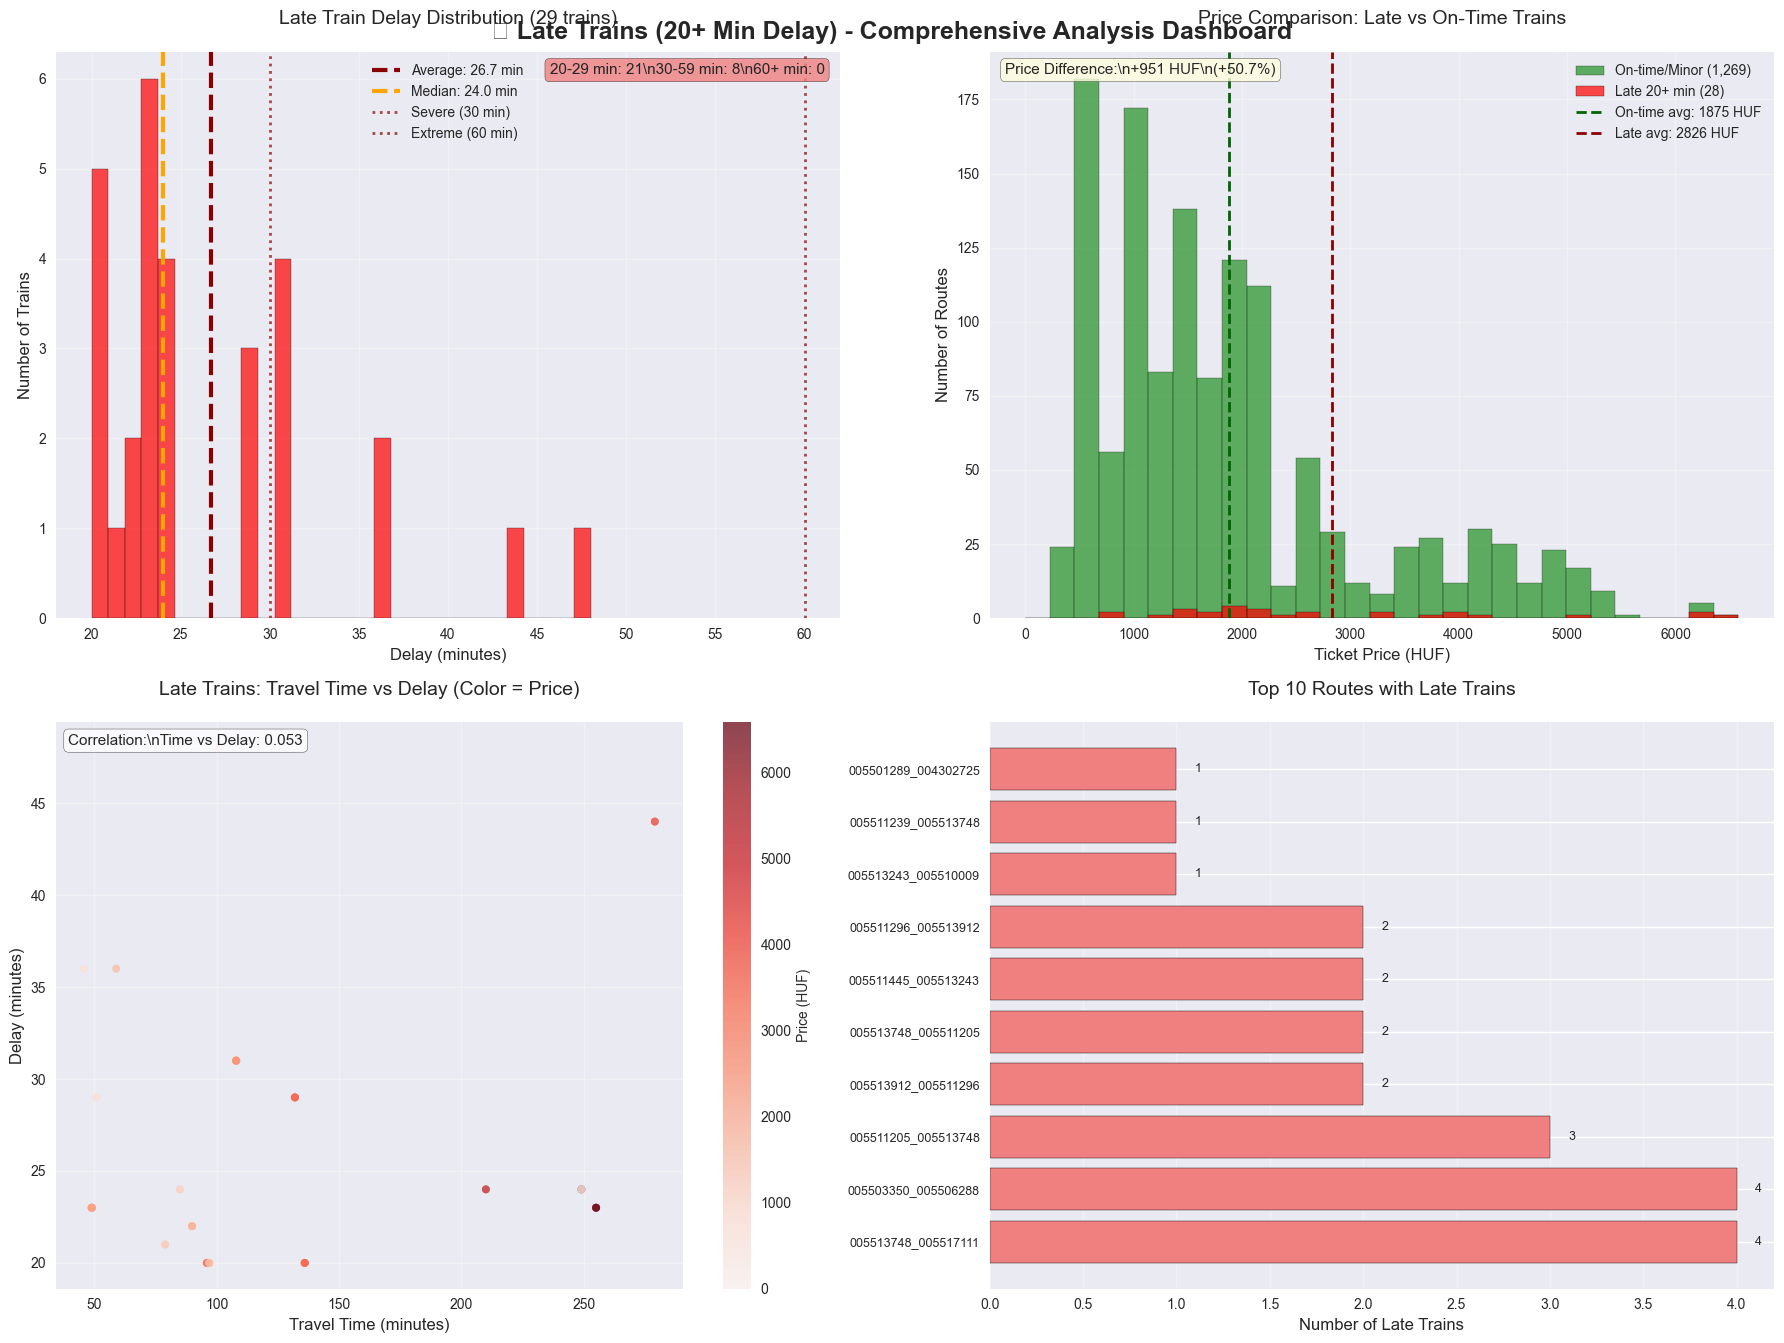

✅ Late trains visualization dashboard complete!


In [27]:
# 📊 LATE TRAINS VISUALIZATION DASHBOARD

if len(late_trains) > 0:
    print("🎨 Creating late trains visualization dashboard...")
    
    # Create a comprehensive dashboard for late trains
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('🔴 Late Trains (20+ Min Delay) - Comprehensive Analysis Dashboard', 
                 fontsize=18, fontweight='bold', y=0.95)
    
    # 1. Late Train Delay Distribution
    axes[0, 0].hist(late_trains['delay_min'], bins=30, alpha=0.7, color='red', edgecolor='black')
    axes[0, 0].axvline(late_trains['delay_min'].mean(), color='darkred', linestyle='--', linewidth=3, 
                      label=f'Average: {late_trains["delay_min"].mean():.1f} min')
    axes[0, 0].axvline(late_trains['delay_min'].median(), color='orange', linestyle='--', linewidth=3, 
                      label=f'Median: {late_trains["delay_min"].median():.1f} min')
    axes[0, 0].axvline(30, color='darkred', linestyle=':', linewidth=2, alpha=0.7, label='Severe (30 min)')
    axes[0, 0].axvline(60, color='maroon', linestyle=':', linewidth=2, alpha=0.7, label='Extreme (60 min)')
    axes[0, 0].set_title(f'Late Train Delay Distribution ({len(late_trains):,} trains)', fontsize=14, pad=20)
    axes[0, 0].set_xlabel('Delay (minutes)', fontsize=12)
    axes[0, 0].set_ylabel('Number of Trains', fontsize=12)
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add severity breakdown text
    moderate_late = len(late_trains[(late_trains['delay_min'] >= 20) & (late_trains['delay_min'] < 30)])
    severe_late = len(late_trains[(late_trains['delay_min'] >= 30) & (late_trains['delay_min'] < 60)])
    extreme_late = len(late_trains[late_trains['delay_min'] >= 60])
    
    axes[0, 0].text(0.98, 0.98, f'20-29 min: {moderate_late:,}\\n30-59 min: {severe_late:,}\\n60+ min: {extreme_late:,}', 
                   transform=axes[0, 0].transAxes, fontsize=11, verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
    
    # 2. Price Comparison: Late vs On-Time Trains (Paid Routes Only)
    late_paid = late_trains[late_trains['price_huf'] > 0]
    ontime_paid = on_time_trains[on_time_trains['price_huf'] > 0]
    
    if len(late_paid) > 0 and len(ontime_paid) > 0:
        # Create side-by-side histograms
        bins = np.linspace(0, min(8000, max(late_paid['price_huf'].max(), ontime_paid['price_huf'].max())), 30)
        axes[0, 1].hist(ontime_paid['price_huf'], bins=bins, alpha=0.6, color='green', 
                       label=f'On-time/Minor ({len(ontime_paid):,})', edgecolor='black')
        axes[0, 1].hist(late_paid['price_huf'], bins=bins, alpha=0.7, color='red', 
                       label=f'Late 20+ min ({len(late_paid):,})', edgecolor='black')
        
        axes[0, 1].axvline(ontime_paid['price_huf'].mean(), color='darkgreen', linestyle='--', linewidth=2, 
                          label=f'On-time avg: {ontime_paid["price_huf"].mean():.0f} HUF')
        axes[0, 1].axvline(late_paid['price_huf'].mean(), color='darkred', linestyle='--', linewidth=2, 
                          label=f'Late avg: {late_paid["price_huf"].mean():.0f} HUF')
        
        axes[0, 1].set_title('Price Comparison: Late vs On-Time Trains', fontsize=14, pad=20)
        axes[0, 1].set_xlabel('Ticket Price (HUF)', fontsize=12)
        axes[0, 1].set_ylabel('Number of Routes', fontsize=12)
        axes[0, 1].legend(fontsize=10)
        axes[0, 1].grid(True, alpha=0.3)
        
        # Add price difference text
        price_diff = late_paid['price_huf'].mean() - ontime_paid['price_huf'].mean()
        axes[0, 1].text(0.02, 0.98, f'Price Difference:\\n{price_diff:+.0f} HUF\\n({price_diff/ontime_paid["price_huf"].mean()*100:+.1f}%)', 
                       transform=axes[0, 1].transAxes, fontsize=11, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    else:
        axes[0, 1].text(0.5, 0.5, 'Insufficient paid route data\\nfor comparison', 
                       transform=axes[0, 1].transAxes, fontsize=14, ha='center', va='center')
        axes[0, 1].set_title('Price Comparison: Not Available', fontsize=14)
    
    # 3. Travel Time vs Delay Scatter Plot
    if len(late_trains) > 0:
        scatter = axes[1, 0].scatter(late_trains['travel_time_minutes'], late_trains['delay_min'], 
                                   c=late_trains['price_huf'], cmap='Reds', alpha=0.7, s=30)
        axes[1, 0].set_title('Late Trains: Travel Time vs Delay (Color = Price)', fontsize=14, pad=20)
        axes[1, 0].set_xlabel('Travel Time (minutes)', fontsize=12)
        axes[1, 0].set_ylabel('Delay (minutes)', fontsize=12)
        axes[1, 0].grid(True, alpha=0.3)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=axes[1, 0])
        cbar.set_label('Price (HUF)', fontsize=10)
        
        # Add correlation info
        if len(late_trains) > 1:
            corr_time_delay = late_trains['travel_time_minutes'].corr(late_trains['delay_min'])
            axes[1, 0].text(0.02, 0.98, f'Correlation:\\nTime vs Delay: {corr_time_delay:.3f}', 
                           transform=axes[1, 0].transAxes, fontsize=11, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 4. Top Affected Routes (Station Pairs)
    if len(late_trains) > 0:
        top_affected = late_trains['station_pair'].value_counts().head(10)
        y_pos = np.arange(len(top_affected))
        
        bars = axes[1, 1].barh(y_pos, top_affected.values, color='lightcoral', edgecolor='black')
        axes[1, 1].set_yticks(y_pos)
        axes[1, 1].set_yticklabels([f'{pair[:20]}...' if len(pair) > 20 else pair for pair in top_affected.index], 
                                  fontsize=9)
        axes[1, 1].set_title('Top 10 Routes with Late Trains', fontsize=14, pad=20)
        axes[1, 1].set_xlabel('Number of Late Trains', fontsize=12)
        axes[1, 1].grid(True, alpha=0.3, axis='x')
        
        # Add count labels on bars
        for i, bar in enumerate(bars):
            width = bar.get_width()
            axes[1, 1].text(width + 0.1, bar.get_y() + bar.get_height()/2, 
                           f'{int(width)}', ha='left', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Late trains visualization dashboard complete!")
    
else:
    print("📊 No late trains to visualize - all trains were on time or had minor delays!")


In [28]:
# 📊 LATE TRAINS SUMMARY & INSIGHTS

print("\n" + "="*80)
print("🎯 LATE TRAINS (20+ MIN) - KEY INSIGHTS & COMPARISONS")
print("="*80)

if len(late_trains) > 0:
    # Detailed comparison between late and on-time trains
    late_paid = late_trains[late_trains['price_huf'] > 0]
    ontime_paid = on_time_trains[on_time_trains['price_huf'] > 0]
    
    print(f"📊 PERFORMANCE COMPARISON:")
    print(f"   🔴 Late trains (20+ min): {len(late_trains):,} ({len(late_trains)/len(df_clean)*100:.1f}% of all trains)")
    print(f"   ✅ On-time/minor delay: {len(on_time_trains):,} ({len(on_time_trains)/len(df_clean)*100:.1f}% of all trains)")
    print()
    
    print(f"💰 PRICING IMPACT ANALYSIS:")
    if len(late_paid) > 0 and len(ontime_paid) > 0:
        avg_price_late = late_paid['price_huf'].mean()
        avg_price_ontime = ontime_paid['price_huf'].mean()
        price_difference = avg_price_late - avg_price_ontime
        price_diff_pct = (price_difference / avg_price_ontime) * 100
        
        print(f"   💵 Average price (late trains): {avg_price_late:.0f} HUF")
        print(f"   💵 Average price (on-time trains): {avg_price_ontime:.0f} HUF")
        print(f"   📈 Price difference: {price_difference:+.0f} HUF ({price_diff_pct:+.1f}%)")
        
        if price_difference > 0:
            print(f"   💡 Late trains cost on average {price_difference:.0f} HUF MORE than on-time trains")
        elif price_difference < 0:
            print(f"   💡 Late trains cost on average {abs(price_difference):.0f} HUF LESS than on-time trains")
        else:
            print(f"   💡 No significant price difference between late and on-time trains")
    else:
        print(f"   ⚠️  Cannot compare prices - insufficient paid route data")
    print()
    
    print(f"🕐 DELAY SEVERITY BREAKDOWN:")
    moderate_late = len(late_trains[(late_trains['delay_min'] >= 20) & (late_trains['delay_min'] < 30)])
    severe_late = len(late_trains[(late_trains['delay_min'] >= 30) & (late_trains['delay_min'] < 60)])
    extreme_late = len(late_trains[late_trains['delay_min'] >= 60])
    
    print(f"   🟡 Moderate delays (20-29 min): {moderate_late:,} trains ({moderate_late/len(late_trains)*100:.1f}% of late trains)")
    print(f"   🟠 Severe delays (30-59 min): {severe_late:,} trains ({severe_late/len(late_trains)*100:.1f}% of late trains)")
    print(f"   🔴 Extreme delays (60+ min): {extreme_late:,} trains ({extreme_late/len(late_trains)*100:.1f}% of late trains)")
    print()
    
    print(f"🚄 OPERATIONAL IMPACT:")
    print(f"   ⏱️  Average delay (late trains): {late_trains['delay_min'].mean():.1f} minutes")
    print(f"   📊 Worst delay recorded: {late_trains['delay_min'].max():.0f} minutes")
    print(f"   🚉 Routes affected by delays: {late_trains['station_pair'].nunique():,} unique pairs")
    print(f"   🔄 Average transfers (late trains): {late_trains['transfers_count'].mean():.1f}")
    print(f"   🔄 Average transfers (on-time): {on_time_trains['transfers_count'].mean():.1f}")
    print()
    
    # Calculate passenger impact
    total_delay_hours = late_trains['delay_min'].sum() / 60
    avg_travel_time_late = late_trains['travel_time_minutes'].mean()
    avg_travel_time_ontime = on_time_trains['travel_time_minutes'].mean()
    
    print(f"📈 PASSENGER IMPACT METRICS:")
    print(f"   ⏰ Total delay time: {total_delay_hours:.1f} hours across all late trains")
    print(f"   🕐 Average travel time (late trains): {avg_travel_time_late:.0f} minutes")
    print(f"   🕐 Average travel time (on-time): {avg_travel_time_ontime:.0f} minutes")
    if avg_travel_time_late > avg_travel_time_ontime:
        print(f"   📊 Late trains take {avg_travel_time_late - avg_travel_time_ontime:.0f} minutes longer on average")
    print()
    
    # Most problematic routes
    print(f"🚨 MOST AFFECTED ROUTES:")
    top_affected = late_trains['station_pair'].value_counts().head(5)
    for i, (route, count) in enumerate(top_affected.items(), 1):
        route_late_data = late_trains[late_trains['station_pair'] == route]
        avg_delay = route_late_data['delay_min'].mean()
        print(f"   {i}. {route}: {count} late trains (avg delay: {avg_delay:.1f} min)")
    print()
    
    # Key recommendations
    print(f"💡 KEY INSIGHTS & RECOMMENDATIONS:")
    late_pct = len(late_trains) / len(df_clean) * 100
    
    if late_pct > 15:
        print(f"   ⚠️  HIGH CONCERN: {late_pct:.1f}% of trains are significantly late (20+ min)")
    elif late_pct > 8:
        print(f"   ⚠️  MODERATE CONCERN: {late_pct:.1f}% of trains are significantly late (20+ min)")
    else:
        print(f"   ✅ GOOD PERFORMANCE: Only {late_pct:.1f}% of trains are significantly late (20+ min)")
    
    if len(late_paid) > 0 and len(ontime_paid) > 0:
        if price_difference > 200:
            print(f"   💰 Price impact: Late trains are significantly more expensive (+{price_difference:.0f} HUF)")
        elif price_difference < -200:
            print(f"   💰 Price benefit: Late trains are actually cheaper (-{abs(price_difference):.0f} HUF)")
        else:
            print(f"   💰 Price neutral: No major price difference between late and on-time trains")
    
    if extreme_late > 0:
        print(f"   🔴 Critical delays: {extreme_late} trains with 60+ minute delays need immediate attention")
    
    print(f"   🎯 Focus areas: Top {min(3, len(top_affected))} most affected routes account for {top_affected.head(3).sum()} late trains")

else:
    print("🎉 EXCELLENT NEWS!")
    print("✅ No trains were significantly late (20+ minutes) in this dataset!")
    print("📊 All trains arrived within 20 minutes of scheduled time.")
    print("🏆 MAV demonstrates excellent punctuality performance.")

print("\n" + "="*80)
print("📋 Late trains analysis complete!")
print("="*80)



🎯 LATE TRAINS (20+ MIN) - KEY INSIGHTS & COMPARISONS
📊 PERFORMANCE COMPARISON:
   🔴 Late trains (20+ min): 29 (2.1% of all trains)
   ✅ On-time/minor delay: 1,329 (97.9% of all trains)

💰 PRICING IMPACT ANALYSIS:
   💵 Average price (late trains): 2826 HUF
   💵 Average price (on-time trains): 1875 HUF
   📈 Price difference: +951 HUF (+50.7%)
   💡 Late trains cost on average 951 HUF MORE than on-time trains

🕐 DELAY SEVERITY BREAKDOWN:
   🟡 Moderate delays (20-29 min): 21 trains (72.4% of late trains)
   🟠 Severe delays (30-59 min): 8 trains (27.6% of late trains)
   🔴 Extreme delays (60+ min): 0 trains (0.0% of late trains)

🚄 OPERATIONAL IMPACT:
   ⏱️  Average delay (late trains): 26.7 minutes
   📊 Worst delay recorded: 48 minutes
   🚉 Routes affected by delays: 17 unique pairs
   🔄 Average transfers (late trains): 0.4
   🔄 Average transfers (on-time): 0.6

📈 PASSENGER IMPACT METRICS:
   ⏰ Total delay time: 12.9 hours across all late trains
   🕐 Average travel time (late trains): 122 

In [29]:
# 📊 LATE RATE NORMALIZED BY TRAVEL TIME

print("\n" + "="*80)
print("⏱️ LATE RATE ANALYSIS NORMALIZED BY TRAVEL TIME")
print("="*80)

# Create travel time bins for analysis
def create_travel_time_bins(df, bin_size_minutes=30):
    """Create travel time bins and calculate late rates for each bin"""
    
    # Create bins (0-30, 30-60, 60-90, etc.)
    max_time = df['travel_time_minutes'].max()
    bins = list(range(0, int(max_time) + bin_size_minutes, bin_size_minutes))
    if bins[-1] < max_time:
        bins.append(int(max_time) + bin_size_minutes)
    
    # Create bin labels
    bin_labels = []
    for i in range(len(bins)-1):
        if bins[i+1] <= 120:  # Show exact minutes for short trips
            bin_labels.append(f"{bins[i]}-{bins[i+1]}min")
        else:  # Show hours for longer trips
            start_hr = bins[i] / 60
            end_hr = bins[i+1] / 60
            bin_labels.append(f"{start_hr:.1f}-{end_hr:.1f}hr")
    
    # Create the bins
    df['travel_time_bin'] = pd.cut(df['travel_time_minutes'], bins=bins, labels=bin_labels, include_lowest=True)
    
    return df, bins, bin_labels

# Apply binning to our cleaned data
LATE_THRESHOLD = 20
df_binned, time_bins, time_labels = create_travel_time_bins(df_clean, bin_size_minutes=30)

# Calculate late rate by travel time bin
travel_time_analysis = []

for bin_label in time_labels:
    bin_data = df_binned[df_binned['travel_time_bin'] == bin_label]
    
    if len(bin_data) > 0:
        total_trains = len(bin_data)
        late_trains = len(bin_data[bin_data['delay_min'] >= LATE_THRESHOLD])
        late_rate = (late_trains / total_trains) * 100
        
        # Calculate average metrics for this bin
        avg_delay = bin_data['delay_min'].mean()
        avg_price = bin_data[bin_data['price_huf'] > 0]['price_huf'].mean() if len(bin_data[bin_data['price_huf'] > 0]) > 0 else 0
        avg_travel_time = bin_data['travel_time_minutes'].mean()
        avg_transfers = bin_data['transfers_count'].mean()
        
        travel_time_analysis.append({
            'travel_time_bin': bin_label,
            'avg_travel_time': avg_travel_time,
            'total_trains': total_trains,
            'late_trains': late_trains,
            'late_rate_pct': late_rate,
            'avg_delay_all': avg_delay,
            'avg_delay_late_only': bin_data[bin_data['delay_min'] >= LATE_THRESHOLD]['delay_min'].mean() if late_trains > 0 else 0,
            'avg_price': avg_price,
            'avg_transfers': avg_transfers
        })

# Convert to DataFrame for easier analysis
travel_analysis_df = pd.DataFrame(travel_time_analysis)

print(f"📊 LATE RATE BY TRAVEL TIME (Late = {LATE_THRESHOLD}+ minutes):")
print("="*60)

for _, row in travel_analysis_df.iterrows():
    print(f"🕐 {row['travel_time_bin']:>12} | "
          f"Trains: {row['total_trains']:>4,} | "
          f"Late: {row['late_trains']:>3} ({row['late_rate_pct']:>5.1f}%) | "
          f"Avg delay: {row['avg_delay_all']:>5.1f}min | "
          f"Avg price: {row['avg_price']:>6.0f}₯")

print("\n📈 KEY INSIGHTS:")
if len(travel_analysis_df) > 0:
    # Find patterns
    highest_late_rate = travel_analysis_df.loc[travel_analysis_df['late_rate_pct'].idxmax()]
    lowest_late_rate = travel_analysis_df.loc[travel_analysis_df['late_rate_pct'].idxmin()]
    
    print(f"   🔴 Highest late rate: {highest_late_rate['travel_time_bin']} ({highest_late_rate['late_rate_pct']:.1f}%)")
    print(f"   ✅ Lowest late rate: {lowest_late_rate['travel_time_bin']} ({lowest_late_rate['late_rate_pct']:.1f}%)")
    
    # Check if there's a correlation between travel time and late rate
    if len(travel_analysis_df) > 2:
        correlation = travel_analysis_df['avg_travel_time'].corr(travel_analysis_df['late_rate_pct'])
        print(f"   📊 Correlation (travel time vs late rate): {correlation:.3f}")
        
        if correlation > 0.3:
            print(f"   💡 FINDING: Longer journeys tend to have higher late rates")
        elif correlation < -0.3:
            print(f"   💡 FINDING: Shorter journeys tend to have higher late rates") 
        else:
            print(f"   💡 FINDING: No strong correlation between journey length and late rates")
    
    # Performance by travel time category
    short_trips = travel_analysis_df[travel_analysis_df['avg_travel_time'] <= 60]
    medium_trips = travel_analysis_df[(travel_analysis_df['avg_travel_time'] > 60) & (travel_analysis_df['avg_travel_time'] <= 180)]
    long_trips = travel_analysis_df[travel_analysis_df['avg_travel_time'] > 180]
    
    print(f"\n🎯 PERFORMANCE BY JOURNEY LENGTH:")
    if len(short_trips) > 0:
        avg_late_rate_short = short_trips['late_rate_pct'].mean()
        print(f"   🚀 Short trips (≤1hr): {avg_late_rate_short:.1f}% average late rate")
    
    if len(medium_trips) > 0:
        avg_late_rate_medium = medium_trips['late_rate_pct'].mean()
        print(f"   🚄 Medium trips (1-3hr): {avg_late_rate_medium:.1f}% average late rate")
    
    if len(long_trips) > 0:
        avg_late_rate_long = long_trips['late_rate_pct'].mean()
        print(f"   🐌 Long trips (3+hr): {avg_late_rate_long:.1f}% average late rate")



⏱️ LATE RATE ANALYSIS NORMALIZED BY TRAVEL TIME
📊 LATE RATE BY TRAVEL TIME (Late = 20+ minutes):
🕐      0-30min | Trains:  108 | Late:   0 (  0.0%) | Avg delay:   1.2min | Avg price:    541₯
🕐     30-60min | Trains:  314 | Late:   7 (  2.2%) | Avg delay:   3.2min | Avg price:   1133₯
🕐     60-90min | Trains:  240 | Late:   4 (  1.7%) | Avg delay:   3.6min | Avg price:   1510₯
🕐    90-120min | Trains:  251 | Late:   8 (  3.2%) | Avg delay:   3.9min | Avg price:   1635₯
🕐    2.0-2.5hr | Trains:  203 | Late:   4 (  2.0%) | Avg delay:   3.7min | Avg price:   2783₯
🕐    2.5-3.0hr | Trains:  126 | Late:   0 (  0.0%) | Avg delay:   3.3min | Avg price:   2815₯
🕐    3.0-3.5hr | Trains:   33 | Late:   1 (  3.0%) | Avg delay:   3.2min | Avg price:   4108₯
🕐    3.5-4.0hr | Trains:   52 | Late:   0 (  0.0%) | Avg delay:   0.9min | Avg price:   4488₯
🕐    4.0-4.5hr | Trains:   23 | Late:   4 ( 17.4%) | Avg delay:  12.5min | Avg price:   5276₯
🕐    4.5-5.0hr | Trains:    8 | Late:   1 ( 12.5%) | Avg

🎨 Creating travel time normalized late rate visualizations...


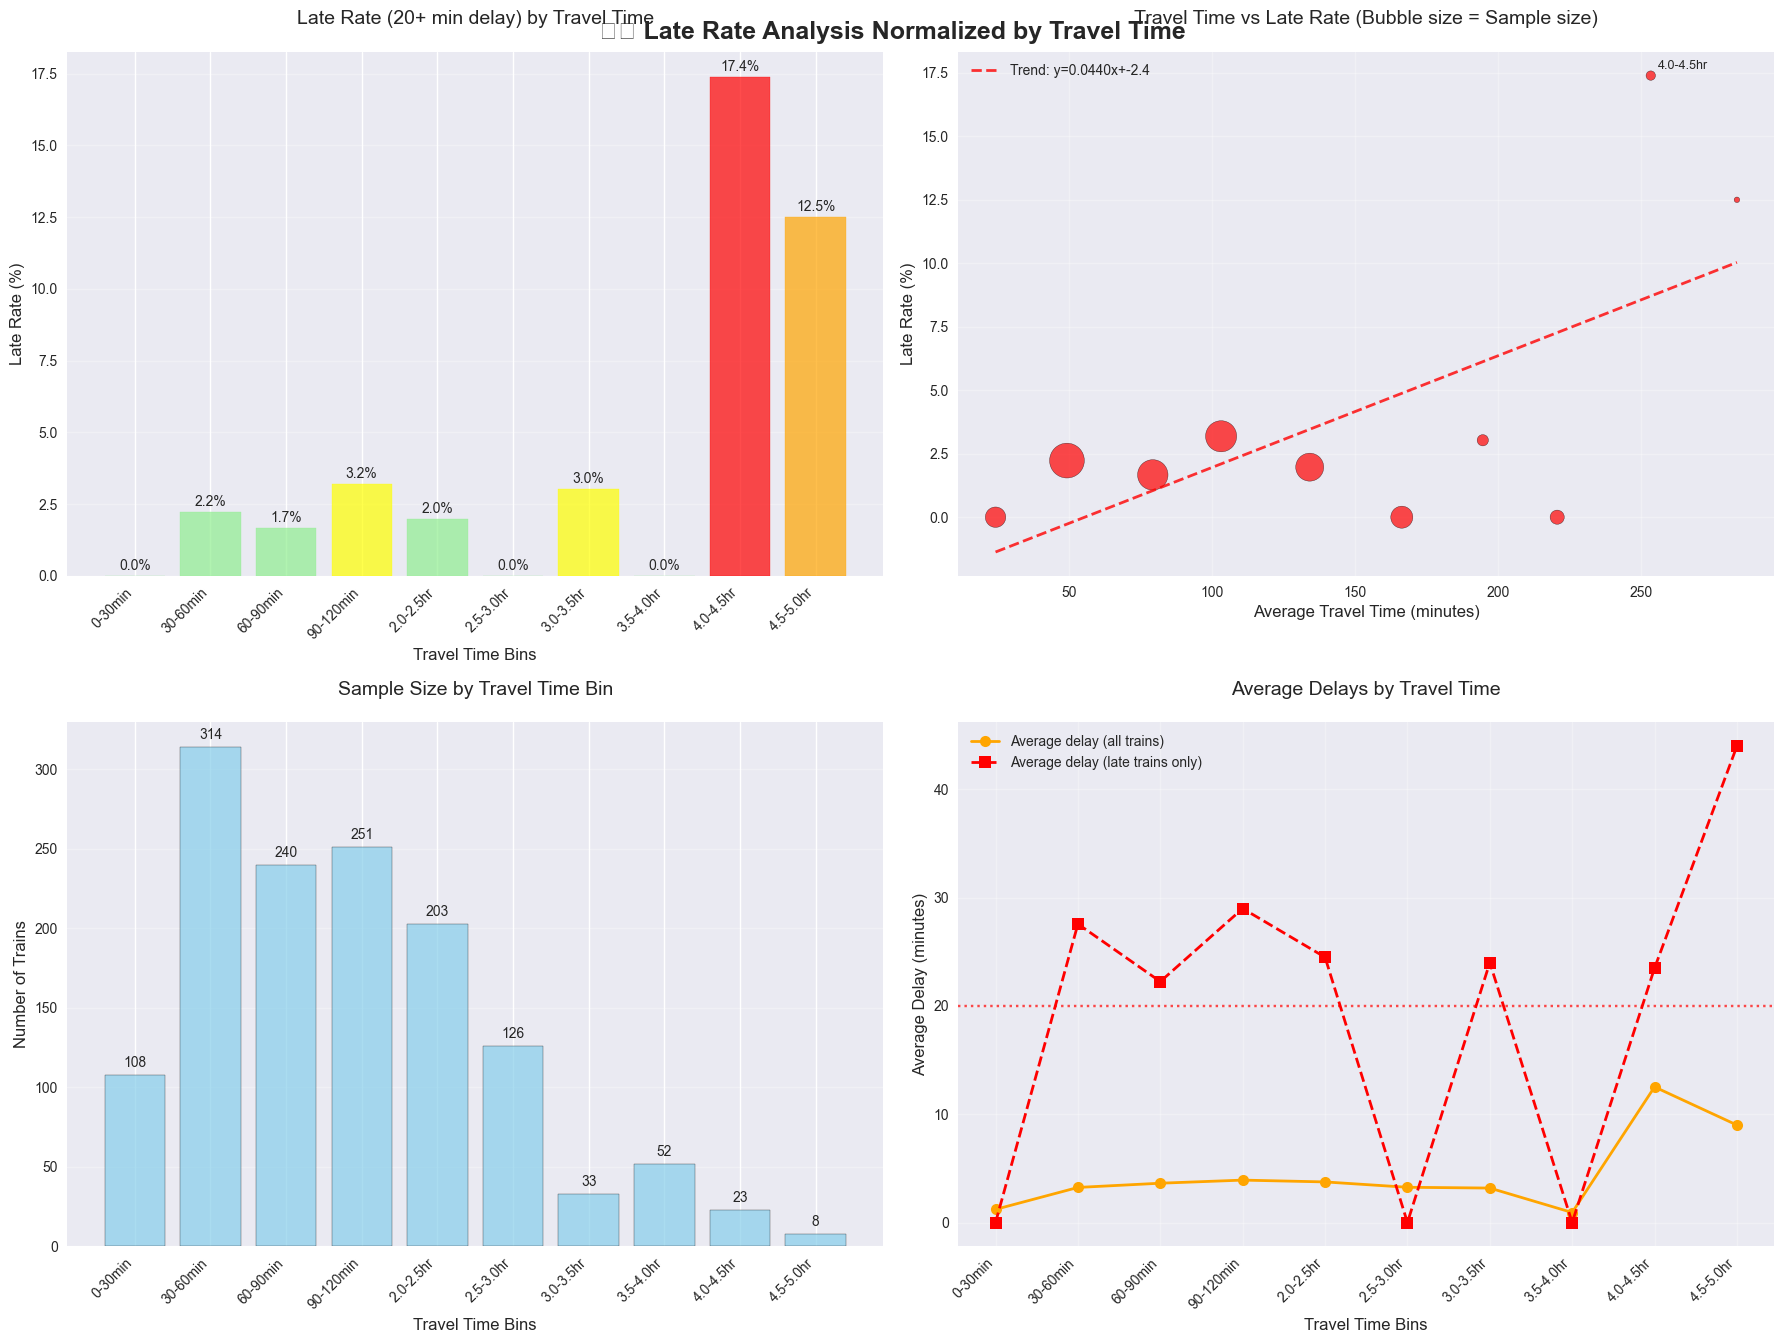


🎯 NORMALIZED LATE RATE INSIGHTS:
   📊 Overall late rate across all travel times: 4.2%
   🚀 Short trips (≤1hr) performance: 1.1% late rate
   🐌 Long trips (3+hr) performance: 8.2% late rate
   ⚠️  Long trips are 7.1% points worse than short trips
   🔴 Problematic travel time ranges:
      • 4.0-4.5hr: 17.4% late rate (23 trains)
      • 4.5-5.0hr: 12.5% late rate (8 trains)
   💡 This normalization shows whether longer journeys are inherently more prone to delays


In [30]:
# 📊 VISUALIZING LATE RATE BY TRAVEL TIME

if len(travel_analysis_df) > 0:
    print("🎨 Creating travel time normalized late rate visualizations...")
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('⏱️ Late Rate Analysis Normalized by Travel Time', 
                 fontsize=18, fontweight='bold', y=0.95)
    
    # 1. Late Rate by Travel Time Bins (Bar Chart)
    x_pos = np.arange(len(travel_analysis_df))
    bars = axes[0, 0].bar(x_pos, travel_analysis_df['late_rate_pct'], 
                         alpha=0.7, color='lightcoral', edgecolor='black')
    
    # Color bars based on late rate severity
    for i, bar in enumerate(bars):
        late_rate = travel_analysis_df.iloc[i]['late_rate_pct']
        if late_rate > 15:
            bar.set_color('red')
        elif late_rate > 8:
            bar.set_color('orange')
        elif late_rate > 3:
            bar.set_color('yellow')
        else:
            bar.set_color('lightgreen')
    
    axes[0, 0].set_xticks(x_pos)
    axes[0, 0].set_xticklabels(travel_analysis_df['travel_time_bin'], rotation=45, ha='right')
    axes[0, 0].set_title('Late Rate (20+ min delay) by Travel Time', fontsize=14, pad=20)
    axes[0, 0].set_xlabel('Travel Time Bins', fontsize=12)
    axes[0, 0].set_ylabel('Late Rate (%)', fontsize=12)
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # Add percentage labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                       f'{height:.1f}%', ha='center', va='bottom', fontsize=10)
    
    # 2. Travel Time vs Late Rate Scatter Plot with Trend Line
    axes[0, 1].scatter(travel_analysis_df['avg_travel_time'], travel_analysis_df['late_rate_pct'], 
                      s=travel_analysis_df['total_trains']*2, # Size by number of trains
                      alpha=0.7, color='red', edgecolors='black')
    
    # Add trend line if we have enough data points
    if len(travel_analysis_df) > 2:
        z = np.polyfit(travel_analysis_df['avg_travel_time'], travel_analysis_df['late_rate_pct'], 1)
        p = np.poly1d(z)
        axes[0, 1].plot(travel_analysis_df['avg_travel_time'], p(travel_analysis_df['avg_travel_time']), 
                       "r--", alpha=0.8, linewidth=2, label=f'Trend: y={z[0]:.4f}x+{z[1]:.1f}')
        axes[0, 1].legend()
    
    axes[0, 1].set_title('Travel Time vs Late Rate (Bubble size = Sample size)', fontsize=14, pad=20)
    axes[0, 1].set_xlabel('Average Travel Time (minutes)', fontsize=12)
    axes[0, 1].set_ylabel('Late Rate (%)', fontsize=12)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Add annotations for outliers
    for i, row in travel_analysis_df.iterrows():
        if row['late_rate_pct'] > travel_analysis_df['late_rate_pct'].mean() + 1.5*travel_analysis_df['late_rate_pct'].std():
            axes[0, 1].annotate(row['travel_time_bin'], 
                               (row['avg_travel_time'], row['late_rate_pct']),
                               xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # 3. Sample Size by Travel Time (to show data reliability)
    axes[1, 0].bar(x_pos, travel_analysis_df['total_trains'], 
                  alpha=0.7, color='skyblue', edgecolor='black')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(travel_analysis_df['travel_time_bin'], rotation=45, ha='right')
    axes[1, 0].set_title('Sample Size by Travel Time Bin', fontsize=14, pad=20)
    axes[1, 0].set_xlabel('Travel Time Bins', fontsize=12)
    axes[1, 0].set_ylabel('Number of Trains', fontsize=12)
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Add count labels
    for i, v in enumerate(travel_analysis_df['total_trains']):
        axes[1, 0].text(i, v + max(travel_analysis_df['total_trains'])*0.01, str(v), 
                       ha='center', va='bottom', fontsize=10)
    
    # 4. Average Delay by Travel Time (for context)
    line = axes[1, 1].plot(x_pos, travel_analysis_df['avg_delay_all'], 
                          marker='o', linewidth=2, markersize=8, color='orange', 
                          label='Average delay (all trains)')
    
    # Add late-only average if we have late trains
    if travel_analysis_df['avg_delay_late_only'].notna().any():
        late_only_data = travel_analysis_df['avg_delay_late_only'].fillna(0)
        axes[1, 1].plot(x_pos, late_only_data, 
                       marker='s', linewidth=2, markersize=8, color='red', linestyle='--',
                       label='Average delay (late trains only)')
    
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(travel_analysis_df['travel_time_bin'], rotation=45, ha='right')
    axes[1, 1].set_title('Average Delays by Travel Time', fontsize=14, pad=20)
    axes[1, 1].set_xlabel('Travel Time Bins', fontsize=12)
    axes[1, 1].set_ylabel('Average Delay (minutes)', fontsize=12)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add horizontal line at 20 minutes (our late threshold)
    axes[1, 1].axhline(y=20, color='red', linestyle=':', alpha=0.7, 
                      label=f'Late threshold ({LATE_THRESHOLD} min)')
    
    plt.tight_layout()
    plt.show()
    
    # Summary insights
    print("\n🎯 NORMALIZED LATE RATE INSIGHTS:")
    
    # Calculate efficiency metrics
    short_efficient = travel_analysis_df[travel_analysis_df['avg_travel_time'] <= 60]['late_rate_pct'].mean() if len(travel_analysis_df[travel_analysis_df['avg_travel_time'] <= 60]) > 0 else 0
    long_efficient = travel_analysis_df[travel_analysis_df['avg_travel_time'] > 180]['late_rate_pct'].mean() if len(travel_analysis_df[travel_analysis_df['avg_travel_time'] > 180]) > 0 else 0
    
    print(f"   📊 Overall late rate across all travel times: {travel_analysis_df['late_rate_pct'].mean():.1f}%")
    print(f"   🚀 Short trips (≤1hr) performance: {short_efficient:.1f}% late rate")
    if long_efficient > 0:
        print(f"   🐌 Long trips (3+hr) performance: {long_efficient:.1f}% late rate")
        if long_efficient > short_efficient:
            print(f"   ⚠️  Long trips are {long_efficient - short_efficient:.1f}% points worse than short trips")
        else:
            print(f"   ✅ Long trips perform similarly or better than short trips")
    
    # Identify problematic travel time ranges
    problematic_bins = travel_analysis_df[travel_analysis_df['late_rate_pct'] > travel_analysis_df['late_rate_pct'].mean() + travel_analysis_df['late_rate_pct'].std()]
    if len(problematic_bins) > 0:
        print(f"   🔴 Problematic travel time ranges:")
        for _, bin_info in problematic_bins.iterrows():
            print(f"      • {bin_info['travel_time_bin']}: {bin_info['late_rate_pct']:.1f}% late rate ({bin_info['total_trains']} trains)")
    
    print("   💡 This normalization shows whether longer journeys are inherently more prone to delays")
    
else:
    print("📊 No travel time data available for normalization analysis")
